In [1]:
import os
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
import sklearn.metrics as sk_metrics
from sklearn.linear_model import LogisticRegression
from nam.wrapper import NAMClassifier
from interpret.utils import measure_interactions
from torch.utils.data import TensorDataset, DataLoader
# from pattern import PatternNet, PatternAttribution
from glob import glob

def parse_filename(path):
    base = os.path.basename(path).replace(".pkl", "")

    # Split based on known format ending: _<snr>_<background>
    parts = base.split("_1d1p_")
    if len(parts) != 2:
        raise ValueError(f"Filename format not recognized: {base}")

    scenario_and_manip, rest = parts
    snr_and_bg = rest.rsplit("_", 1)  # split SNR vs background

    if len(snr_and_bg) != 2:
        raise ValueError(f"Could not parse SNR and background from: {rest}")
    
    snr_str, background = snr_and_bg

    # Now split scenario and manip from the RIGHT
    scenario_parts = scenario_and_manip.rsplit("_", 1)
    if len(scenario_parts) != 2:
        raise ValueError(f"Could not parse scenario and manip_type from: {scenario_and_manip}")
    
    scenario, manip_type = scenario_parts

    try:
        snr_value = eval(snr_str.replace("_", ","))
    except Exception:
        snr_value = snr_str

    return scenario, manip_type, snr_value, background
    
random_state = 1
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")
# device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
device_str = 'cpu'


def FAST(X_train, y_train, n_interactions, init_score=None, feature_names=None, feature_types=None):
    top_interactions = measure_interactions(
        X_train, y_train,
        interactions=n_interactions,
        init_score=init_score,
        feature_names=feature_names,
        feature_types=feature_types
    )
    return [(i, j) for (i, j), _ in top_interactions]

def plot_weight_and_signal_grids(
    Z_train,
    w,
    interaction_pairs,
    D,
    title_prefix="",
    filename_prefix="",
    cmap='magma',
    show=False
):
    # Step 1: Compute signal
    Sigma_Z = np.cov(Z_train.T)
    signal_Z = Sigma_Z @ w

    w = np.abs(w)
    signal_Z = np.abs(signal_Z)
    main_weights = w[:D]
    inter_weights = w[D:]
    main_signal = signal_Z[:D]
    inter_signal = signal_Z[D:]

    # Step 2: Build redistribution matrices
    full_weights_matrix = np.zeros((D, D))
    full_signal_matrix = np.zeros((D, D))

    for i in range(D):
        full_weights_matrix[i, i] = main_weights[i]
        full_signal_matrix[i, i] = main_signal[i]

    for idx, (i, j) in enumerate(interaction_pairs):
        full_weights_matrix[i, j] += inter_weights[idx]
        full_weights_matrix[j, i] += inter_weights[idx]
        full_signal_matrix[i, j] += inter_signal[idx]
        full_signal_matrix[j, i] += inter_signal[idx]

    # Step 3: Plotting helper
    def plot_feature_grid(matrix, title, filename, show=show):
        fig, axs = plt.subplots(8, 8, figsize=(10, 10))
        vmax = np.max(np.abs(matrix))
        for k in range(D):
            ax = axs[k // 8, k % 8]
            image = matrix[k].reshape(8, 8)
            im = ax.imshow(image, cmap=cmap, vmin=0, vmax=vmax)
            ax.axis('off')
        fig.suptitle(title, fontsize=14, y=0.98)
        plt.tight_layout()
        plt.savefig(f'./figures/{filename}.png', bbox_inches='tight')
        plt.savefig(f'./figures/{filename}_hires.png', bbox_inches='tight', dpi=300)
        # if show:
        #     plt.show()

    # Step 4: Plot weights and signal
    plot_feature_grid(full_weights_matrix, f"{title_prefix} Weights", f"{filename_prefix}_weights")
    plot_feature_grid(full_signal_matrix, f"{title_prefix} Activation Patterns", f"{filename_prefix}_patterns")

def get_symmetric_ticks(min_val, max_val):
    return np.round([min_val, 0.0, max_val], 2)

def plot_shape_functions(
    model,
    X_train,
    patterns,
    num_cols=8,
    group1_indices=[],
    group2_indices=[],
    group3_indices=[],
    group1_color=(0.6, 0.8, 1.0, 0.3),
    group2_color=(1.0, 0.75, 0.5, 0.3),
    group3_color=(0.72, 0.78, 0.85, 0.51),
    group1_label="Signal",
    group2_label="Distractor",
    group3_label="Overlap",
    filename='',
    figsize=(20, 8),
    show=False
):
    D = X_train.shape[1]
    num_rows = int(np.ceil(D / num_cols))
    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    axs = axs.ravel()

    X_train = X_train.to(device)

    global_min_raw = np.inf
    global_max_raw = -np.inf
    global_min_scaled = np.inf
    global_max_scaled = -np.inf

    # Precompute all preds
    feature_preds = []

    for feature_idx in range(D):
        x_vals_real = torch.linspace(
            X_train[:, feature_idx].min(),
            X_train[:, feature_idx].max(),
            steps=1000
        ).cpu().numpy()

        X_query = torch.zeros((len(x_vals_real), D), dtype=torch.float32, device=device)
        X_query[:, feature_idx] = torch.tensor(x_vals_real, dtype=torch.float32, device=device)

        preds_raw_all = []
        preds_scaled_all = []

        for learner_idx, learner in enumerate(model.models):
            learner.eval()
            learner.to(device)
            with torch.no_grad():
                _, _, main_effects_out, _ = learner.forward(X_query)
                raw_preds = main_effects_out[:, feature_idx].cpu().numpy().flatten()
                pattern_scaled_preds = raw_preds * np.abs(patterns[learner_idx][feature_idx])

                preds_raw_all.append(raw_preds)
                preds_scaled_all.append(pattern_scaled_preds)

        preds_raw_all = np.stack(preds_raw_all, axis=0)
        preds_scaled_all = np.stack(preds_scaled_all, axis=0)

        mean_raw_preds = np.mean(preds_raw_all, axis=0)
        mean_scaled_preds = np.mean(preds_scaled_all, axis=0)

        # Update global limits
        global_min_raw = min(global_min_raw, np.min(mean_raw_preds))
        global_max_raw = max(global_max_raw, np.max(mean_raw_preds))
        global_min_scaled = min(global_min_scaled, np.min(mean_scaled_preds))
        global_max_scaled = max(global_max_scaled, np.max(mean_scaled_preds))

        feature_preds.append((x_vals_real, preds_raw_all, mean_raw_preds, preds_scaled_all, mean_scaled_preds))

    # Now plot
    for feature_idx in range(D):
        ax = axs[feature_idx]
        ax2 = ax.twinx()

        x_vals_real, preds_raw_all, mean_raw_preds, preds_scaled_all, mean_scaled_preds = feature_preds[feature_idx]

        ax.plot(x_vals_real, mean_raw_preds, color='blue', alpha=1.0, linewidth=1, label='Raw Mean')

        
        ax2.plot(x_vals_real, mean_scaled_preds, color='red', alpha=1.0, linewidth=1, label='Pattern-Scaled Mean')

        # --- Compute global min/max (already available) ---
        raw_min, raw_max = global_min_raw, global_max_raw
        scaled_min, scaled_max = global_min_scaled, global_max_scaled

        # Force symmetric limits around zero
        raw_abs_max = max(abs(raw_min), abs(raw_max))
        scaled_abs_max = max(abs(scaled_min), abs(scaled_max))

        ax.set_ylim(-raw_abs_max, raw_abs_max)
        ax2.set_ylim(-scaled_abs_max, scaled_abs_max)

        ax.set_yticks(np.round([-raw_abs_max, 0.0, raw_abs_max], 2))
        ax2.set_yticks(np.round([-scaled_abs_max, 0.0, scaled_abs_max], 2))

        # x-limits
        ax.set_xlim(-1.0, 1.0)

        # Aesthetics
        ax.yaxis.label.set_color('blue')
        ax2.yaxis.label.set_color('red')
        ax.tick_params(axis='y', colors='blue', labelsize=8)
        ax2.tick_params(axis='y', colors='red', labelsize=8)

        # Hide y-ticks for non-edge columns
        if feature_idx % num_cols != 0:
            ax.set_yticks([])
        if feature_idx % num_cols != num_cols - 1:
            ax2.set_yticks([])

        # Hide x-ticks for non-bottom rows
        if feature_idx // num_cols != num_rows - 1:
            ax.set_xticks([])

        if feature_idx in group1_indices:
            ax.set_facecolor(group1_color)
        elif feature_idx in group2_indices:
            ax.set_facecolor(group2_color)
        elif feature_idx in group3_indices:
            ax.set_facecolor(group3_color)
        
        # ax.set_title(f"Feature {feature_idx}", fontsize=8, color='black')  


    legend_elements = []
    if group1_indices:
        legend_elements.append(mpatches.Patch(facecolor=group1_color, label=group1_label))
    if group2_indices:
        legend_elements.append(mpatches.Patch(facecolor=group2_color, label=group2_label))
    if group3_indices:
        legend_elements.append(mpatches.Patch(facecolor=group3_color, label=group3_label))
    if legend_elements:
        fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.025))

    fig.text(0.025, 1.02, 'Shape Functions', ha='left', va='top', fontsize=14, color='blue')
    fig.text(0.975, 1.02, 'PatternGAM', ha='right', va='top', fontsize=14, color='red')

    

    plt.tight_layout()
    if filename:
        plt.savefig(f'./figures/{filename}_hires.png', bbox_inches='tight', dpi=300)
        plt.savefig(f'./figures/{filename}.png', bbox_inches='tight')
    # if show:
    #     plt.show()

OUT_DIR = './figures'
os.makedirs(OUT_DIR, exist_ok=True)

SAVE_DIR = './saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

from scipy.stats import zscore

def fit_llr_single_feature(z_col, y_np, *, random_state=1):
    """
    Fit logistic regression: y ~ 1 + zscore(z_col).
    Returns (b, d) where eta = b * zstd + d and p = sigmoid(eta).
    If z_col has ~zero variance, returns b=0, d=logit(base rate).
    """
    z = np.asarray(z_col).reshape(-1)
    y = np.asarray(y_np).reshape(-1).astype(int)

    zstd = zscore(z, axis=None, ddof=0)
    if (not np.isfinite(zstd).any()) or np.allclose(np.nan_to_num(zstd, nan=0.0), 0.0):
        p = np.clip(y.mean(), 1e-6, 1-1e-6)
        return 0.0, float(np.log(p/(1-p)))

    X = np.nan_to_num(zstd, nan=0.0, posinf=0.0, neginf=0.0).reshape(-1, 1)
    lr = LogisticRegression(penalty=None, fit_intercept=True, solver='lbfgs',
                            max_iter=10000, random_state=random_state)
    lr.fit(X, y)
    return float(lr.coef_[0, 0]), float(lr.intercept_[0])

def compute_patterns(model, X_train, y_train):
    """
    Returns:
      avg_pattern a, list of per-learner patterns, and w on z-scored Z_mean.
      IMPORTANT CHANGE: the post-hoc LLR is fit on z-scored Z (columns z-score).
    """
    Z_all = []
    patterns = []

    # per-learner patterns (fit on that learner's Z but with z-score)
    for learner in model.models:
        learner.eval()
        learner.to(device)
        with torch.no_grad():
            X_train_tensor = X_train.to(dtype=torch.float32).to(device)
            _, _, main_effects_out, interaction_effects_out = learner.forward(X_train_tensor)
            if interaction_effects_out.shape[1] > 0:
                Z = torch.cat([main_effects_out, interaction_effects_out], dim=1)  # (N,U)
            else:
                Z = main_effects_out
            Z_np = Z.cpu().numpy()
            Z_all.append(Z_np)

        Zstd = zscore(Z_np, axis=0, ddof=0)
        Zstd = np.nan_to_num(Zstd, nan=0.0, posinf=0.0, neginf=0.0)

        cov_Z = np.cov(Zstd.T)
        linreg = LogisticRegression(penalty=None, fit_intercept=True, max_iter=5000, random_state=random_state)
        linreg.fit(Zstd, y_train)
        w_Z = linreg.coef_[0]                               # (U,)

        yhat = Zstd @ w_Z                                   # linear decision (no sigmoid)
        var_yhat = np.var(yhat, ddof=0) if np.var(yhat, ddof=0) > 0 else 1e-12

        patterns.append((cov_Z @ w_Z) / var_yhat)           # pattern on z-scored Z

    Z_all = np.stack(Z_all, axis=0)                         # (L, N, U)
    Z_mean = np.mean(Z_all, axis=0)                         # (N, U)

    Zstd_mean = zscore(Z_mean, axis=0, ddof=0)
    Zstd_mean = np.nan_to_num(Zstd_mean, nan=0.0, posinf=0.0, neginf=0.0)

    cov_Z = np.cov(Zstd_mean.T)
    linreg = LogisticRegression(penalty=None, fit_intercept=True, max_iter=5000, random_state=random_state)
    linreg.fit(Zstd_mean, y_train)
    w_Z = linreg.coef_[0]

    yhat = Zstd_mean @ w_Z
    var_yhat = np.var(yhat, ddof=0) if np.var(yhat, ddof=0) > 0 else 1e-12

    avg_pattern = (cov_Z @ w_Z) / var_yhat
    return avg_pattern, patterns, w_Z


Using device: cpu


/Users/benny/braindata/pattern-gam-neurips/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from scipy.stats import zscore 
def zscore_standardisation(data):
    standardised = np.zeros(data.shape)
    for i in range(data.shape[1]):
        standardised[:,i] = zscore(data[:,i], nan_policy='omit')
    standardised[np.isnan(standardised)] = 0
    return torch.tensor(standardised)

In [4]:
# interactions = 0
# pkl_path = './data/xai_tris/linear_distractor_additive_1d1p_0.03_0.49_0.49_correlated_0.pkl' 
# scen_title=f'linear_distractor_correlated_{interactions}'

interactions = 256
pkl_path = './data/xai_tris/xor_distractor_additive_1d1p_0.20_0.40_0.40_correlated_0.pkl' 
# pkl_path = './data/xai_tris/xor_distractor_additive_1d1p_0.10_0.45_0.45_correlated_0.pkl' 

scen_title=f'xor_distractor_correlated_{interactions}'

# Load data

with open(pkl_path, "rb") as f:
    data = pkl.load(f)

X_train = data.x_train
y_train = data.y_train
X_val = data.x_val
y_val = data.y_val
X_test = data.x_test
y_test = data.y_test

if interactions == 0:
    interaction_pairs = []
else:
    interaction_pairs = FAST(X_train, y_train, n_interactions=interactions)

model = NAMClassifier(
        num_epochs=100,
        num_learners=1,
        metric='auroc',
        interaction_pairs=interaction_pairs,
        hidden_sizes = [16,16,16],
        early_stop_mode='max',
        device=device_str,
        monitor_loss=False,
        dropout=0.2,
        feature_dropout=0.2,
        output_reg=0.2,
        # dropout=0.0,
        # feature_dropout=0.0,
        # output_reg=0.0,
        val_split=0.05, # 9000 train, 500 val -> 500/9500 roughly is 0.05.
        n_jobs=10,
        activation='relu',
        random_state=random_state
    )

model.fit(torch.cat((X_train, X_val), dim=0), torch.cat((y_train, y_val), dim=0))

pred = model.predict_proba(X_test.float())
auroc = sk_metrics.roc_auc_score(y_test, pred)
print(f"{pkl_path} n_interactions={interactions}, AUROC={auroc:.3f}")

./data/xai_tris/xor_distractor_additive_1d1p_0.20_0.40_0.40_correlated_0.pkl n_interactions=256, AUROC=0.656


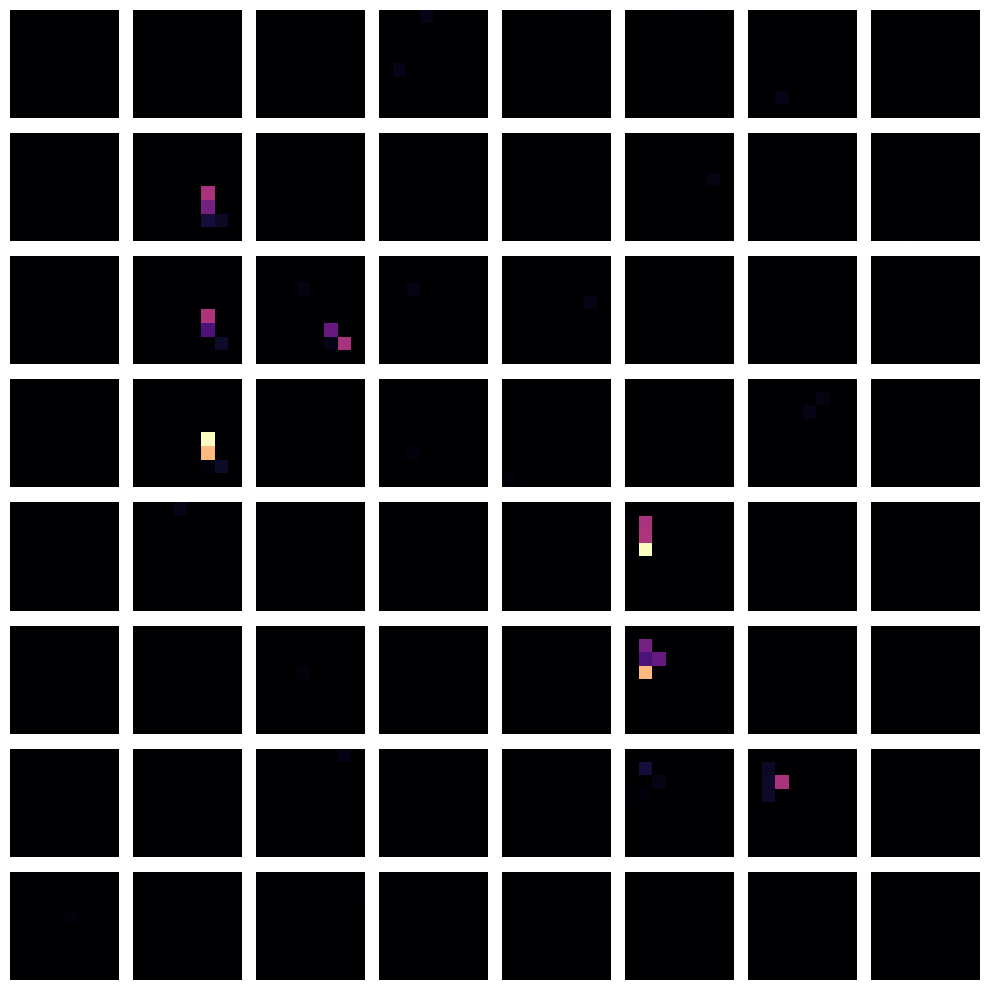

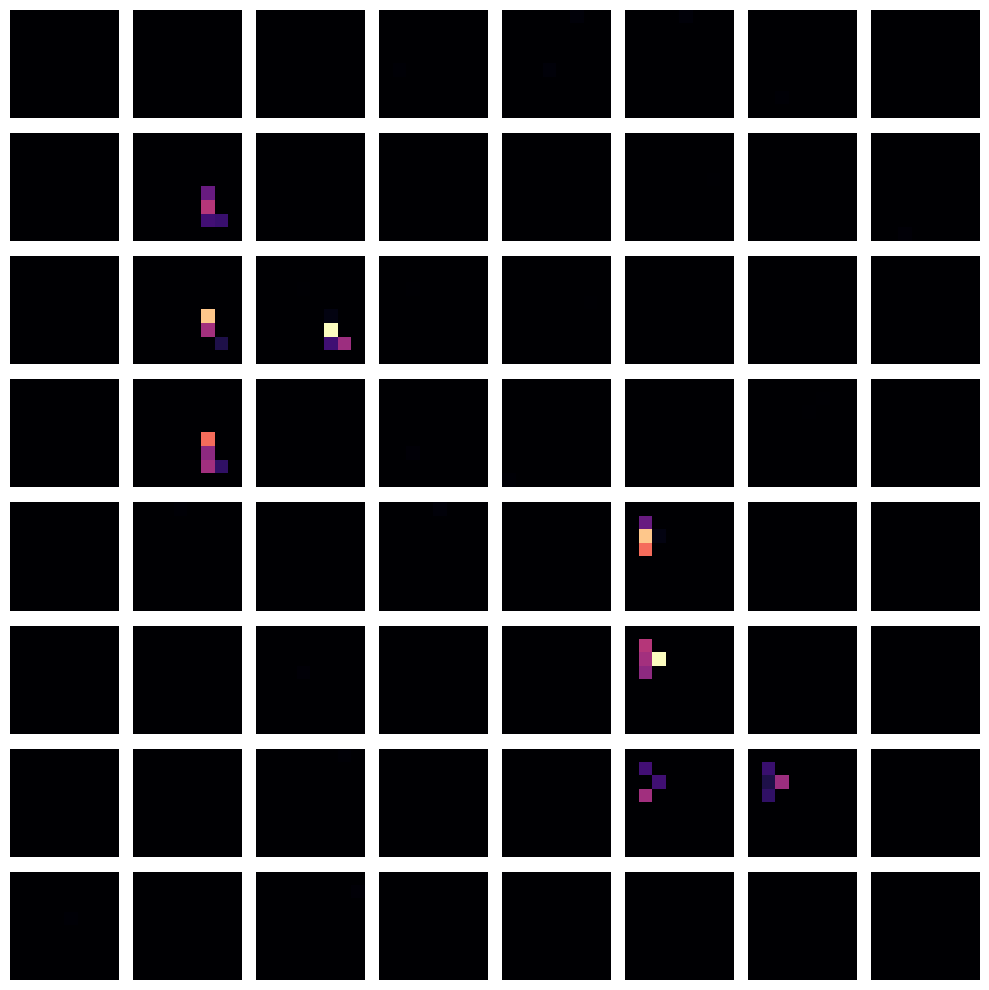

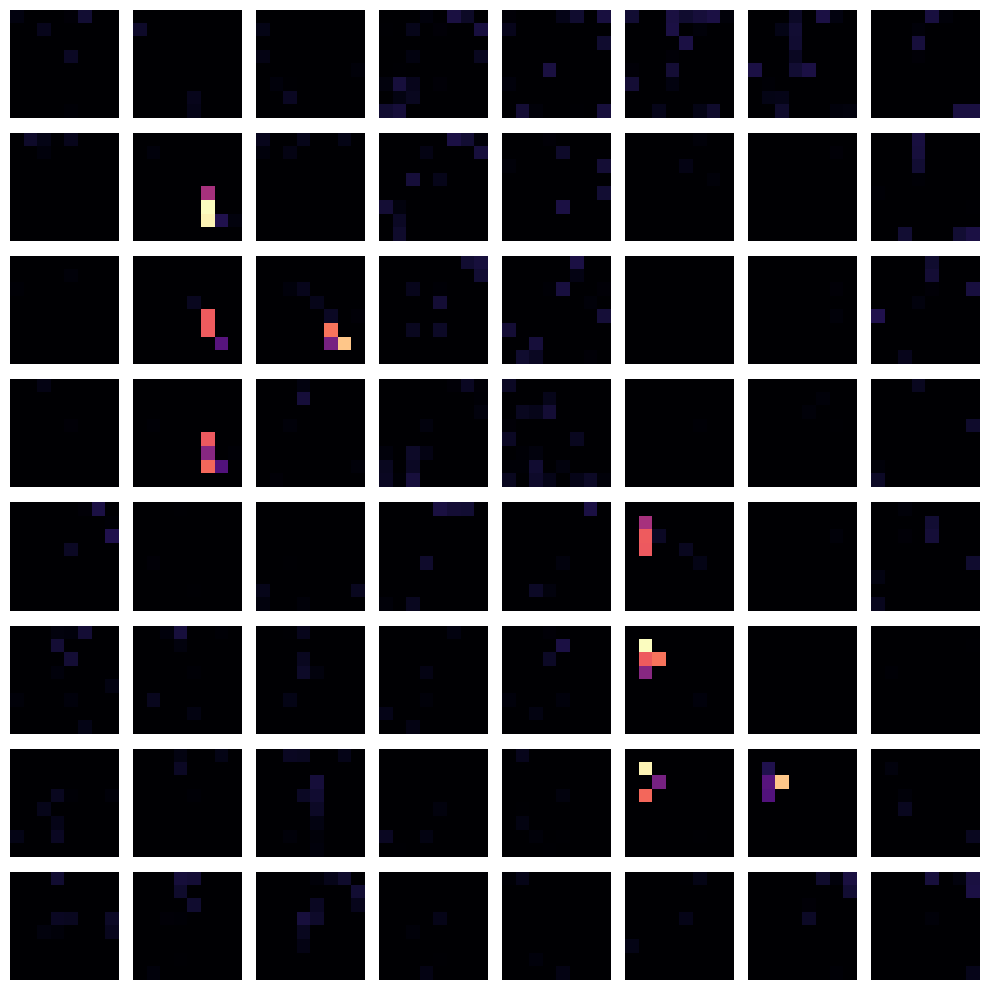

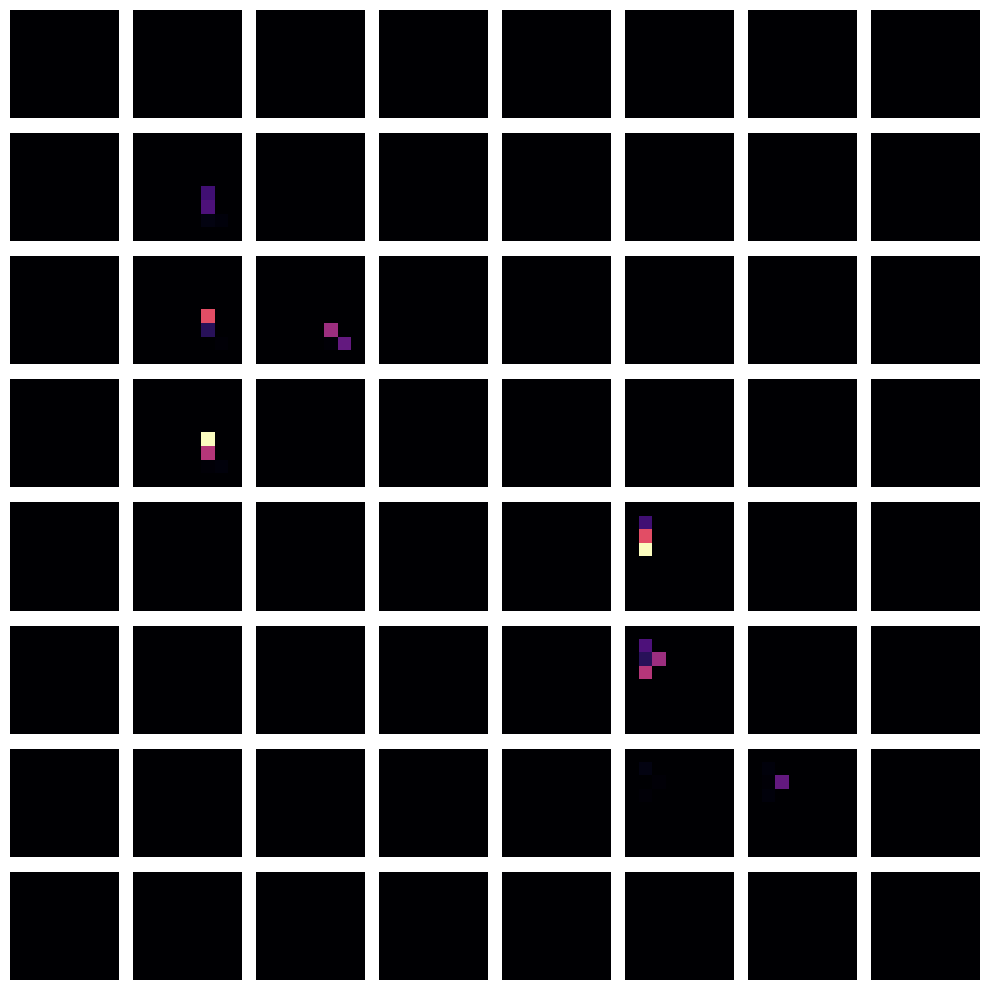

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def _discr(scores, y):
    """DISCR(s) = 2*(AUC-0.5), 0 on failure."""
    try:
        return 2.0 * (roc_auc_score(y, scores) - 0.5)
    except Exception:
        return 0.0

def _fit_llr_1d(x, y, *, rs=1):
    """Fit y ~ 1 + x (1-D logistic); return slope b and intercept d."""
    lr = LogisticRegression(penalty=None, solver='lbfgs',
                            fit_intercept=True, max_iter=10000, random_state=rs)
    lr.fit(x.reshape(-1, 1), y.astype(int))
    return float(lr.coef_[0, 0]), float(lr.intercept_[0])

def compute_tilde_metrics_from_Z(Z, y):
    """
    Inputs:
      Z : (N, U) raw NAM features f_i (main effects first, then interactions)
      y : (N,) binary {0,1}

    Steps:
      1) Fit multivariate post-hoc LLR: y ~ 1 + Z  -> weights w (size U)
      2) For each i: \tilde{f}_i = w_i * f_i
         - SD_tilde[i]     = SD(\tilde{f}_i)
         - Fit 1-D LLR on \tilde{f}_i -> slope b_i; SDb_tilde[i] = SD(b_i * \tilde{f}_i)
         - DISCR_tilde[i]  = 2*(AUC(\tilde{f}_i, y) - 0.5)
         - PROD_tilde[i]   = SD_tilde[i] * SDb_tilde[i]
    Returns:
      dict with keys: 'w', 'SD_tilde', 'SDb_tilde', 'DISCR_tilde', 'PROD_tilde'
    """
    Z = np.asarray(Z, dtype=float)
    y = np.asarray(y).astype(int).ravel()
    N, U = Z.shape

    # (1) Multivariate post-hoc logistic regression (intercept included)
    lr_all = LogisticRegression(penalty=None, solver='lbfgs',
                                fit_intercept=True, max_iter=10000, random_state=1)
    lr_all.fit(Z, y)
    w = lr_all.coef_[0]  # (U,)

    # (2) Per-feature metrics on \tilde{f}_i
    SD_tilde     = np.zeros(U, dtype=float)
    SDb_tilde    = np.zeros(U, dtype=float)
    DISCR_tilde  = np.zeros(U, dtype=float)
    PROD_tilde   = np.zeros(U, dtype=float)

    for i in range(U):
        tilde = w[i] * Z[:, i]                         # \tilde{f}_i
        SD_t = float(np.std(tilde, ddof=0))            # SD(\tilde{f}_i)
        # 1-D logistic on \tilde{f}_i -> b_i
        try:
            b_i, _ = _fit_llr_1d(tilde, y, rs=17 + i)
        except Exception:
            b_i = 0.0
        SDb_t = float(np.std(b_i * tilde, ddof=0))     # SD(b_i * \tilde{f}_i)
        DISCR = _discr(tilde, y)                       # DISCR(\tilde{f}_i)
        PROD  = SD_t * SDb_t                            # product

        SD_tilde[i]    = SD_t
        SDb_tilde[i]   = SDb_t
        DISCR_tilde[i] = DISCR
        PROD_tilde[i]  = PROD

    return dict(
        w=w,
        SD_tilde=SD_tilde,
        SDb_tilde=SDb_tilde,
        DISCR_tilde=DISCR_tilde,
        PROD_tilde=PROD_tilde
    )

def _redistribute_unitwise_to_DxD(main_vec, inter_vec, interaction_pairs, D):
    """
    Place |main_vec| on the diagonal and spread |inter_vec| symmetrically
    to (i,j) and (j,i) for each interaction pair.
    """
    M = np.zeros((D, D), dtype=float)
    # main effects on diagonal
    for i in range(min(D, len(main_vec))):
        M[i, i] = abs(main_vec[i])
    # interactions
    for k, (i, j) in enumerate(interaction_pairs):
        v = abs(inter_vec[k])
        M[i, j] += v
        M[j, i] += v
    return M

def plot_feature_grids_metrics(
    Z, y, interaction_pairs, D,
    title_prefix="", filename_prefix="", cmap='magma'
):
    """
    Plot four grids using \tilde{f}_i metrics:
      1) SD(\tilde{f}_i)
      2) SD(b_i * \tilde{f}_i)
      3) DISCR(\tilde{f}_i)
      4) SD(\tilde{f}_i) × SD(b_i * \tilde{f}_i)
    """
    M = compute_tilde_metrics_from_Z(Z, y)
    U = Z.shape[1]
    num_inters = len(interaction_pairs)
    main = slice(0, D)
    inter = slice(D, D + num_inters)

    def make_grid(vec):
        main_vec = vec[main]
        inter_vec = vec[inter] if num_inters > 0 else np.zeros(0)
        return _redistribute_unitwise_to_DxD(main_vec, inter_vec, interaction_pairs, D)

    grids = {
        "SD_tilde":   make_grid(M["SD_tilde"]),
        "SDb_tilde":  make_grid(M["SDb_tilde"]),
        "DISCR":      make_grid(M["DISCR_tilde"]),
        "PROD":       make_grid(M["PROD_tilde"]),
    }

    def _plot_grid(G, title, fname):
        fig, axs = plt.subplots(8, 8, figsize=(10, 10))
        vmax = float(np.max(np.abs(G)))
        for k in range(D):
            ax = axs[k // 8, k % 8]
            ax.imshow(G[k].reshape(8, 8), cmap=cmap, vmin=0, vmax=vmax)
            ax.axis('off')
        # fig.suptitle(title, fontsize=14, y=0.98)
        plt.tight_layout()
        plt.savefig(f'./figures/cameraready_{fname}.png', bbox_inches='tight')
        plt.savefig(f'./figures/cameraready_{fname}_hires.png', bbox_inches='tight', dpi=300)

    _plot_grid(grids["SD_tilde"],  f"{title_prefix} SD($\\tilde{{f}}_i$)",              f"{filename_prefix}_SD_tilde")
    _plot_grid(grids["SDb_tilde"], f"{title_prefix} SD($b_i\\tilde{{f}}_i$)",           f"{filename_prefix}_SDb_tilde")
    _plot_grid(grids["DISCR"],     f"{title_prefix} DISCR($\\tilde{{f}}_i$)",           f"{filename_prefix}_DISCR_tilde")
    _plot_grid(grids["PROD"],      f"{title_prefix} SD($\\tilde{{f}}_i$)$\\times$SD($b_i\\tilde{{f}}_i$)",
                                     f"{filename_prefix}_PROD_tilde")

    return grids, M


with torch.no_grad():
    learner = model.models[0]
    learner.eval(); learner.to(device)
    _, _, me_out, int_out = learner.forward(torch.cat((X_train, X_val), dim=0).to(device))
    Z_train = torch.cat([me_out, int_out], dim=1).cpu().numpy() if int_out.shape[1] > 0 else me_out.cpu().numpy()

y_for_Z = torch.cat((y_train, y_val), dim=0).cpu().numpy().astype(int).ravel()
D = X_train.shape[1]


grids_tilde, metrics_tilde = plot_feature_grids_metrics(
    Z_train, y_for_Z,
    interaction_pairs=interaction_pairs,
    D=D,
    title_prefix=scen_title,
    filename_prefix=f"{scen_title}_metrics_tilde",
    cmap='magma'
)


In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression

def _extract_Z_mean_main(model, X_tensor, device):
    """Ensemble-mean main-effect matrix Z (N, d); ignores interactions."""
    X_tensor = X_tensor.to(dtype=torch.float32, device=device)
    Zs = []
    with torch.no_grad():
        for learner in model.models:
            learner.eval(); learner.to(device)
            _, _, me_out, _ = learner.forward(X_tensor)
            Zs.append(me_out.detach().cpu().numpy())
    return np.mean(np.stack(Zs, axis=0), axis=0)  # (N, d)

def _fit_multivar_llr_w(Z, y, *, standardize_for_fit=False, random_state=1):
    """
    Fit y ~ 1 + Z (logistic).
    If standardize_for_fit=True, fit on z-scored columns and map weights back:
      w_raw = w_std / SD_raw  so that  tilde = w_raw * f(x)  (no change in curves).
    """
    from sklearn.linear_model import LogisticRegression
    Z = np.asarray(Z, float)
    y = np.asarray(y, int).ravel()
    if standardize_for_fit:
        sd = Z.std(axis=0, ddof=0); sd_safe = np.where(sd > 0, sd, 1.0)
        Z_fit = (Z - Z.mean(axis=0)) / sd_safe
    else:
        sd_safe = None
        Z_fit = Z
    lr = LogisticRegression(penalty=None, solver='lbfgs',
                            fit_intercept=True, max_iter=10000, random_state=random_state)
    lr.fit(Z_fit, y)
    w_fit = lr.coef_[0]
    return (w_fit / sd_safe) if standardize_for_fit else w_fit

def _fit_univar_llr_b_d(x, y, *, random_state=1):
    """Fit y ~ 1 + x (logistic) on raw x; return slope b and intercept d."""
    from sklearn.linear_model import LogisticRegression
    try:
        lr = LogisticRegression(penalty=None, solver='lbfgs',
                                fit_intercept=True, max_iter=10000, random_state=random_state)
        lr.fit(x.reshape(-1, 1), y.astype(int))
        return float(lr.coef_[0, 0]), float(lr.intercept_[0])
    except Exception:
        return 0.0, 0.0

def plot_shape_functions_tilde_pgM(
    model,
    X_train,              # torch.Tensor (N, d) in the model's input scale
    y_train,              # torch.Tensor or np.ndarray (N,)
    *,
    device=torch.device('cpu'),
    num_cols=8,
    group1_indices=None,
    group2_indices=None,
    group3_indices=None,
    group1_color=(0.6, 0.8, 1.0, 0.3),
    group2_color=(1.0, 0.75, 0.5, 0.3),
    group3_color=(0.72, 0.78, 0.85, 0.51),
    group1_label="Signal",
    group2_label="Distractor",
    group3_label="Overlap",
    filename='',
    figsize=(20, 8),
    xlim=(-1.0,1.0),
    show=False,
    standardize_for_fit=False,  # optional diagnostic; weights mapped back so tilde is unchanged
):
    """
    Per-feature (univariate) plots:
      - Black (left y-axis, shared lim):   \tilde f_j(x) = w_j * f_j(x)
      - Red   (right y-axis, shared lim):  f^{PG-M}_j(x) = b_j * \tilde f_j(x) + d_j
    (b_j,d_j) from univariate LLR on sampled \tilde z_j = w_j * Z_{·j}. No centering, no z-scoring.
    """
    if group1_indices is None: group1_indices = []
    if group2_indices is None: group2_indices = []
    if group3_indices is None: group3_indices = []

    # 1) Build Z on training samples (ensemble mean of main effects)
    X_train = X_train.to(device)
    y_np = y_train.detach().cpu().numpy().astype(int).ravel() if torch.is_tensor(y_train) else np.asarray(y_train, int).ravel()
    Z_train = _extract_Z_mean_main(model, X_train, device)   # (N, d)
    d = Z_train.shape[1]

    # 2) Multivariate post-hoc LLR -> w (mapped to raw units if standardized for fit)
    w = _fit_multivar_llr_w(Z_train, y_np, standardize_for_fit=standardize_for_fit, random_state=1)  # (d,)

    # 3) Per-feature univariate fits on sampled tilde z
    b = np.zeros(d); d0 = np.zeros(d)
    for j in range(d):
        tilde_z_j = w[j] * Z_train[:, j]                    # NO de-meaning
        bj, dj = _fit_univar_llr_b_d(tilde_z_j, y_np, random_state=17 + j)
        b[j], d0[j] = bj, dj

    # 4) Precompute curves over full observed x-range (model input space)
    num_rows = int(np.ceil(d / num_cols))
    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    axs = axs.ravel()

    curves = []  # dicts: x, tilde(x), pgm(x)
    # track shared limits separately for black and red sets
    blk_min = np.inf; blk_max = -np.inf
    red_min = np.inf; red_max = -np.inf

    for j in range(d):
        x_min = float(X_train[:, j].min().cpu().item())
        x_max = float(X_train[:, j].max().cpu().item())
        x_vals = np.linspace(-0.5, 0.5, 1000, dtype=np.float32)

        Xq = torch.zeros((len(x_vals), d), dtype=torch.float32, device=device)
        Xq[:, j] = torch.tensor(x_vals, dtype=torch.float32, device=device)

        with torch.no_grad():
            preds_all = []
            for learner in model.models:
                learner.eval(); learner.to(device)
                _, _, me_out, _ = learner.forward(Xq)
                preds_all.append(me_out[:, j].detach().cpu().numpy().ravel())
            f_mean = np.mean(np.stack(preds_all, axis=0), axis=0)   # f_j(x)

        f_tilde = w[j] * f_mean                                     # \tilde f_j(x) (NO centering)
        f_pgM   = b[j] * f_tilde + d0[j]                            # PG-M

        curves.append(dict(x=x_vals, tilde=f_tilde, pgm=f_pgM))
        blk_min = min(blk_min, float(np.min(f_tilde))); blk_max = max(blk_max, float(np.max(f_tilde)))
        red_min = min(red_min, float(np.min(f_pgM)));   red_max = max(red_max, float(np.max(f_pgM)))

    # Shared symmetric limits (separately) for black and red axes
    blk_m = max(abs(blk_min), abs(blk_max)); blk_ylim = (-1.005*blk_m, 1.005*blk_m) if blk_m > 0 else (-0.05, 0.05)
    red_m = max(abs(red_min), abs(red_max)); red_ylim = (-1.005*red_m, 1.005*red_m) if red_m > 0 else (-0.05, 0.05)

    # 5) Plot with twin axes; show black ticks on leftmost col, red ticks on rightmost col
    for j in range(d):
        ax_left = axs[j]
        ax_right = ax_left.twinx()

        c = curves[j]
        ax_left.plot(c["x"], c["tilde"], color='black', linewidth=1.2, label=r'$\tilde f_j(x)$')
        ax_right.plot(c["x"], c["pgm"],   color='red',   linewidth=1.0, label=r'$b_j\tilde f_j(x)+d_j$')

        ax_left.set_ylim(*blk_ylim)
        ax_right.set_ylim(*red_ylim)

        # background highlighting
        if j in group1_indices:
            ax_left.set_facecolor(group1_color)
        elif j in group2_indices:
            ax_left.set_facecolor(group2_color)
        elif j in group3_indices:
            ax_left.set_facecolor(group3_color)

        ax_left.tick_params(axis='x', labelsize=11)
        ax_left.set_xlim(xlim)
        ax_right.set_xlim(xlim)
        ax_left.set_xticks([-0.5, 0, 0.5])

        # ticks: only leftmost shows black ticks; only rightmost shows red ticks
        col_idx = j % num_cols
        row_idx = j // num_cols
        if col_idx != 0:
            ax_left.set_yticks([])
        else:
            # 3-tick symmetric labels for black axis
            a = blk_ylim[1]; ax_left.set_yticks([ -a, 0.0,  a ])
        if col_idx != (num_cols - 1):
            ax_right.set_yticks([])
        else:
            a = red_ylim[1]; ax_right.set_yticks([ -a, 0.0,  a ])
        if row_idx != (num_rows - 1):
            ax_left.set_xticks([])

        ax_left.tick_params(axis='y', colors='black', labelsize=12)
        ax_right.tick_params(axis='y', colors='red',   labelsize=12)

    # legends and headers
    legend_elements = []
    if group1_indices: legend_elements.append(mpatches.Patch(facecolor=group1_color, label=group1_label))
    if group2_indices: legend_elements.append(mpatches.Patch(facecolor=group2_color, label=group2_label))
    if group3_indices: legend_elements.append(mpatches.Patch(facecolor=group3_color, label=group3_label))
    if legend_elements:
        fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.025), fontsize=15)

    fig.text(0.07, 1.005, r'$f^\text{GAM}$', ha='left', va='top', fontsize=18, color='black')
    fig.text(0.95, 1.005,  r'$f^\text{PGAM}$', ha='right', va='top', fontsize=18, color='red')

    

    plt.tight_layout()
    if filename:
        plt.savefig(f'./figures/cameraready_{filename}_hires.png', bbox_inches='tight', dpi=300)
        plt.savefig(f'./figures/cameraready_{filename}.png', bbox_inches='tight')
    if show:
        plt.show()

    plt.subplots_adjust(hspace=0.15, wspace=0.15)
    # Return parameters if you want to reuse them elsewhere
    return dict(w=w, b=b, d=d0, blk_ylim=blk_ylim, red_ylim=red_ylim)


In [12]:
interactions = 0
pkl_path = './data/xai_tris/linear_distractor_additive_1d1p_0.05_0.47_0.47_correlated_0.pkl' 
scen_title=f'linear_distractor_correlated_{interactions}'

# interactions = 0
# pkl_path = './data/xai_tris/multiplicative_distractor_multiplicative_1d1p_0.40_0.30_0.30_correlated_0.pkl' 
# scen_title=f'multiplicative_distractor_correlated_{interactions}'

# interactions = 256
# # pkl_path = './data/xai_tris/xor_distractor_additive_1d1p_0.20_0.40_0.40_correlated_0.pkl' 
# pkl_path = './data/xai_tris/xor_distractor_additive_1d1p_0.10_0.45_0.45_correlated_0.pkl' 
# scen_title=f'xor_distractor_correlated_{interactions}'

# Load data

with open(pkl_path, "rb") as f:
    data = pkl.load(f)

X_train = data.x_train
y_train = data.y_train
X_val = data.x_val
y_val = data.y_val
X_test = data.x_test
y_test = data.y_test

if interactions == 0:
    interaction_pairs = []
else:
    interaction_pairs = FAST(X_train, y_train, n_interactions=interactions)

model = NAMClassifier(
        num_epochs=100,
        num_learners=1,
        metric='auroc',
        interaction_pairs=interaction_pairs,
        hidden_sizes = [16,16,16],
        early_stop_mode='max',
        device=device_str,
        monitor_loss=False,
        dropout=0.2,
        feature_dropout=0.2,
        output_reg=0.2,
        # dropout=0.0,
        # feature_dropout=0.0,
        # output_reg=0.0,
        val_split=0.05, # 9000 train, 500 val -> 500/9500 roughly is 0.05.
        n_jobs=10,
        activation='relu',
        random_state=random_state+1
    )

model.fit(torch.cat((X_train, X_val), dim=0), torch.cat((y_train, y_val), dim=0))

pred = model.predict_proba(X_test.float())
auroc = sk_metrics.roc_auc_score(y_test, pred)
print(f"{pkl_path} n_interactions={interactions}, AUROC={auroc:.3f}")

./data/xai_tris/linear_distractor_additive_1d1p_0.05_0.47_0.47_correlated_0.pkl n_interactions=0, AUROC=0.781


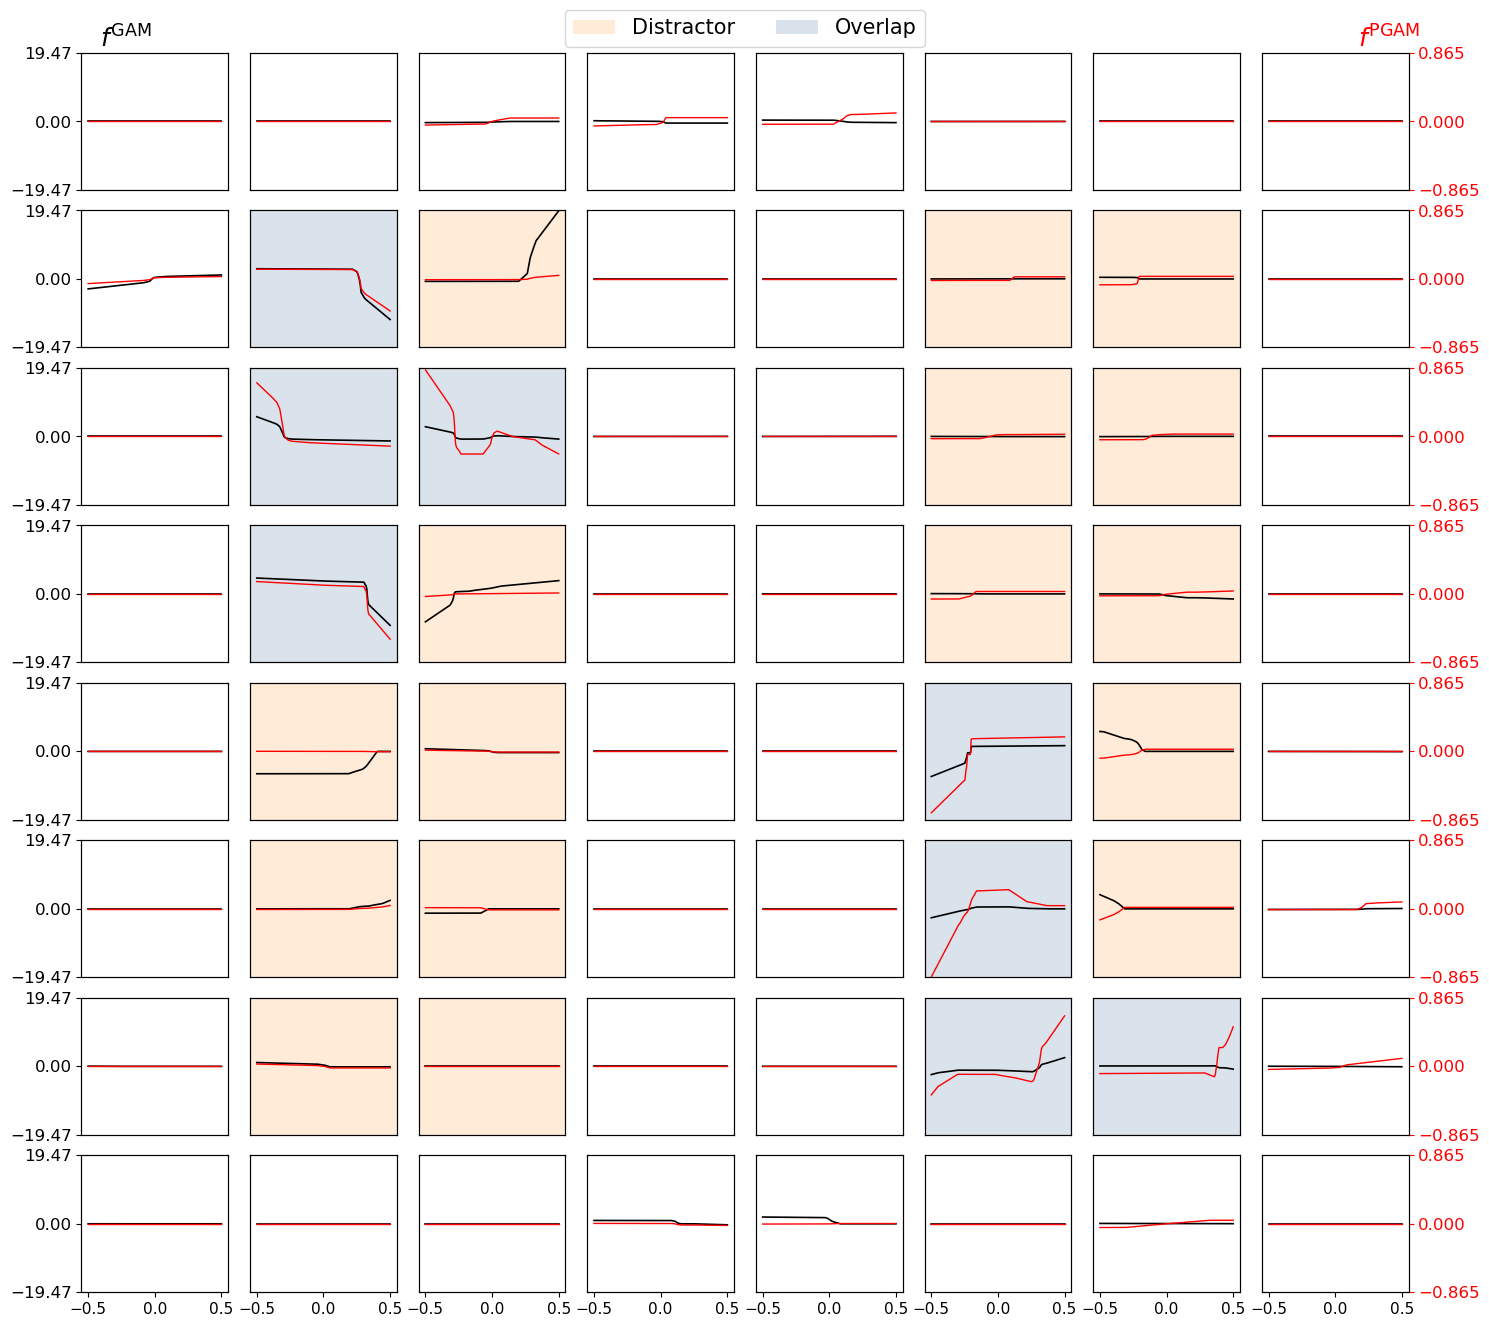

In [13]:
# ## If using the 2x2 distractors
# gt_inds = [25, 53,54]  # Ground truth inds
# distractor_inds = [10, 13,14,21,22, 41,42,49,50, 38,46]
# overlap_inds = [9,17,18, 37,45]

# if using the 2x3 fully overlapping distractors
gt_inds = []
distractor_inds = [10,26, 13,14,21,22, 29,30, 33,34, 41,42,49,50, 38,46]
overlap_inds = [9,17,18,25, 37,45,53,54]

rgba_blue = (0.6, 0.8, 1.0, 0.3)   # light blue, semi-transparent
rgba_orange = (1.0, 0.75, 0.5, 0.3)  # light orange, semi-transparent
overlap_colour = (130/255,215/255,127/255,0.5)

if scen_title == '':
    scen_title = 'xai_tris'

_ = plot_shape_functions_tilde_pgM(
    model,
    X_train,           # same tensor you trained NAM on (or train+val)
    y_train,
    device=device,
    num_cols=8,
    group1_indices=gt_inds,
    group2_indices=distractor_inds,
    group3_indices=overlap_inds,
    filename=scen_title,
    figsize=(15, 13),
    xlim=(-0.55,0.55),
    show=False,
    standardize_for_fit=False 
)


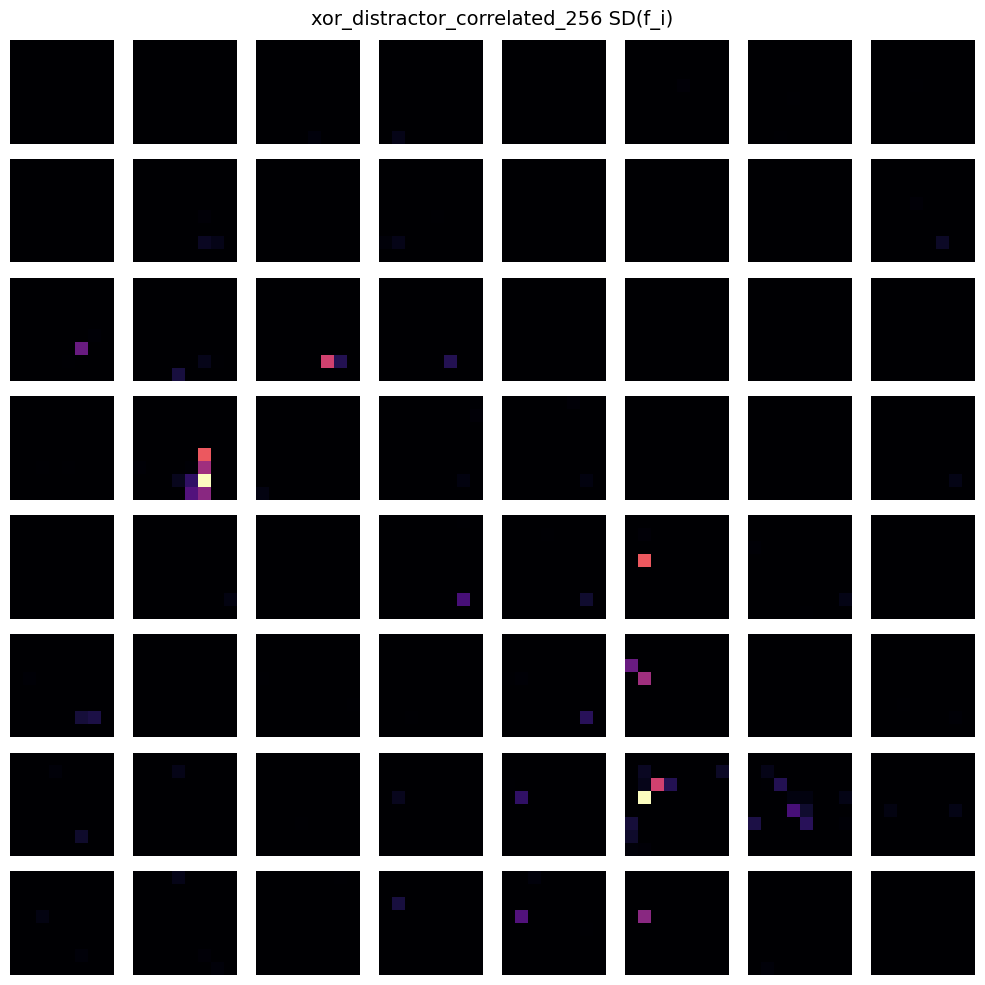

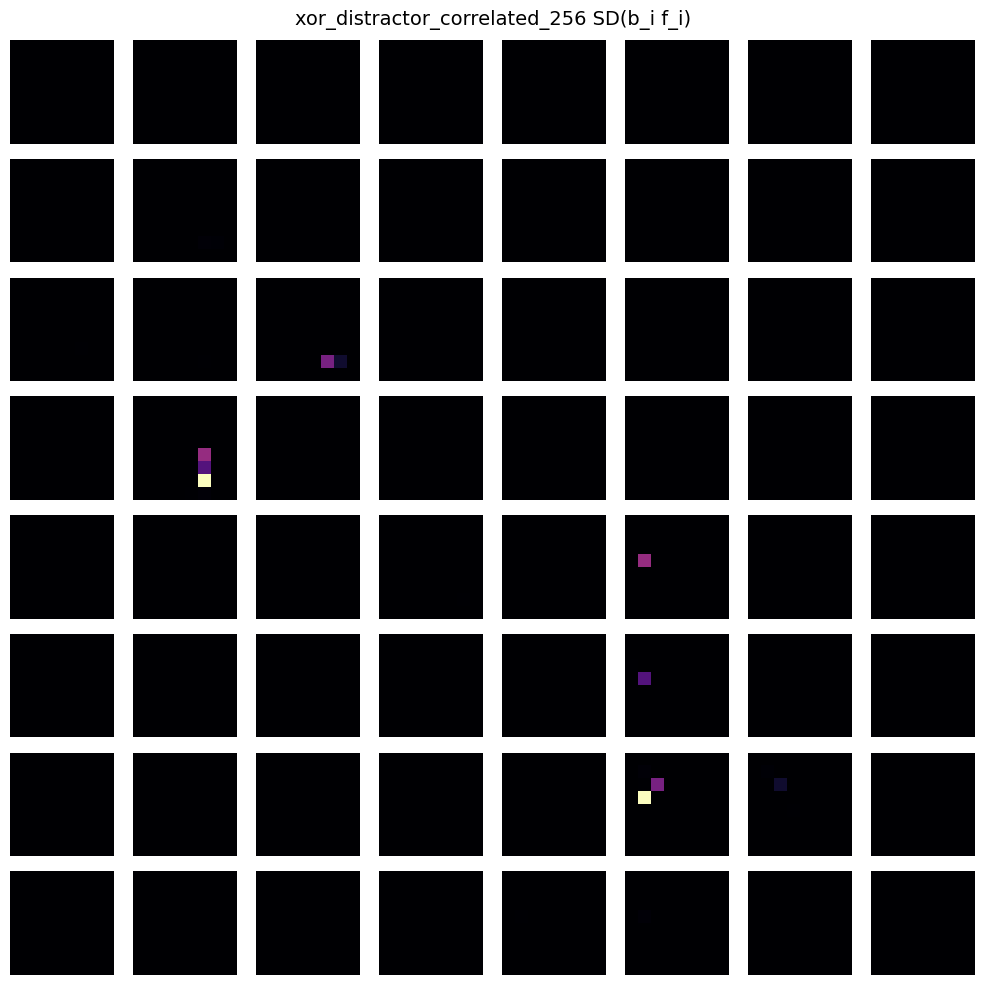

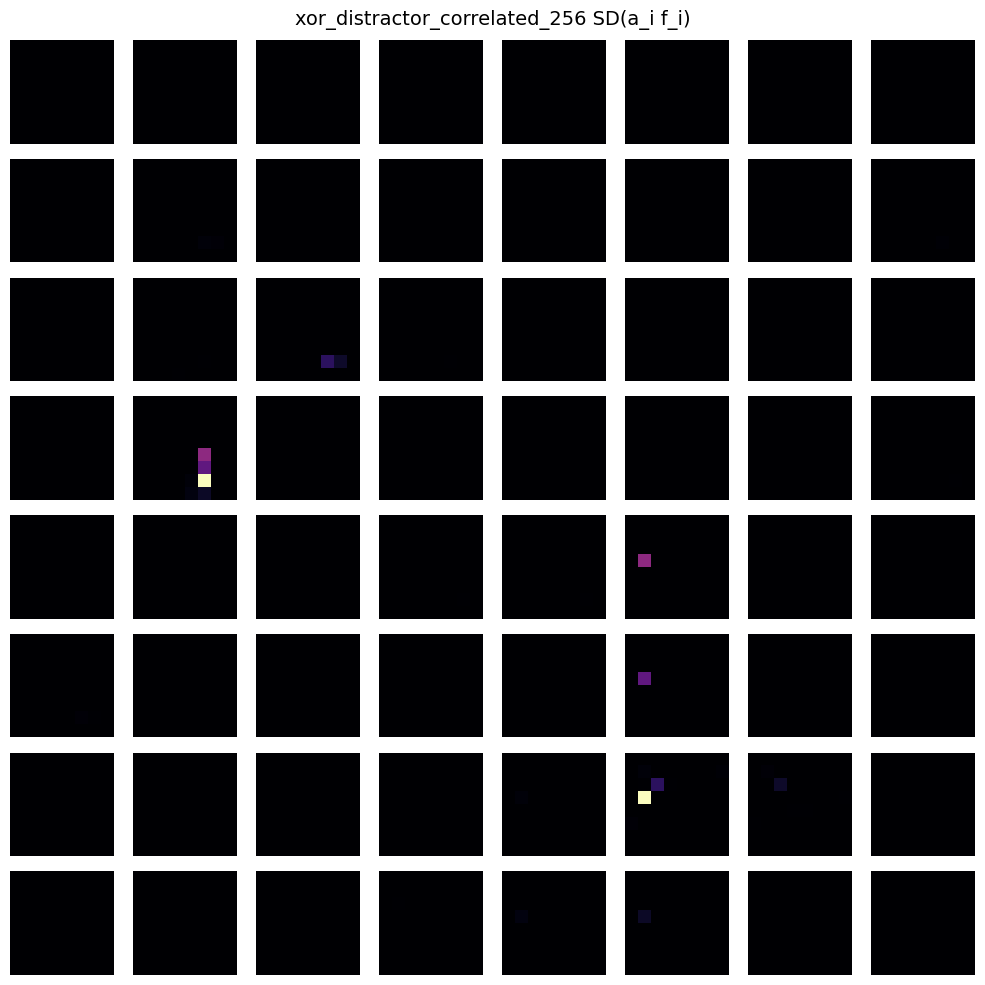

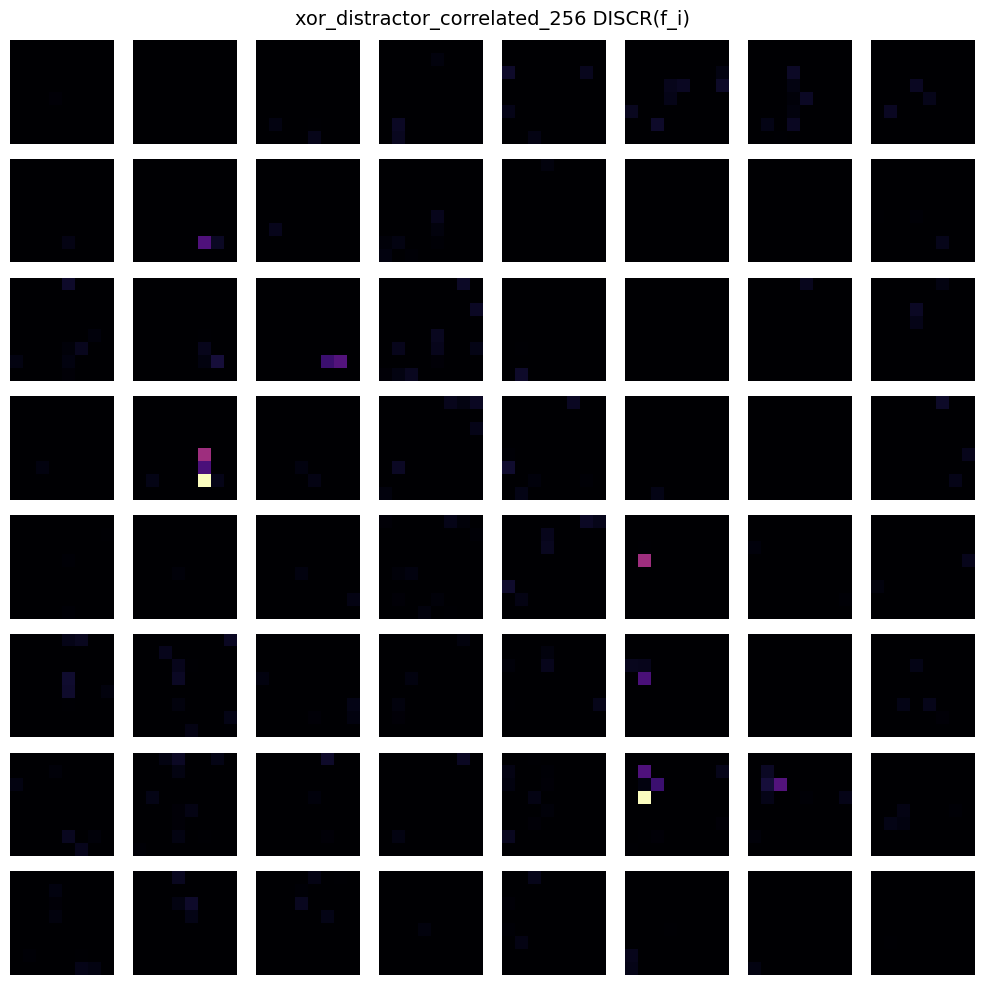

In [60]:
# from scipy.stats import zscore
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score
# import numpy as np

# def compute_unitwise_metrics_from_Z(Z_train, y_train, *, sd_mode="raw"):
#     """
#     Z_train : (N, U) RAW NAM features (main first, then interactions).
#     y_train : (N,) or (N,1), binary {0,1}.

#     Trains:
#       - b_i via 1-D logistic on z-scored f_i
#       - a_i (pattern) from post-hoc LLR on z-scored Z

#     Returns dict with:
#       sd_f_u_raw     : SD(f_i) on RAW Z
#       sd_f_u_std     : SD(f_i) on z-scored Z (~1)
#       discr_u        : DISCR(f_i) computed on RAW Z (AUC-based)
#       b_u, a_u       : slopes/patterns trained on z-scored columns
#       sdbf_u,  sdaf_u: SD(b_i f_i), SD(a_i f_i) using the basis chosen by sd_mode
#       sdbf_raw,sdaf_raw; sdbf_std,sdaf_std : both variants for convenience

#     sd_mode ∈ {"raw","zscored"} controls which SD basis is used for sdbf_u / sdaf_u.
#     """
#     y = np.asarray(y_train).reshape(-1).astype(int)
#     Z = np.asarray(Z_train, dtype=float)
#     N, U = Z.shape

#     # --- RAW stats (always compute)
#     sd_f_u_raw = Z.std(axis=0, ddof=0)                 # SD(f_i) on RAW Z
#     discr_u = np.zeros(U, dtype=float)                 # DISCR on RAW Z
#     for i in range(U):
#         zi = Z[:, i]
#         try:
#             auc = roc_auc_score(y, zi)
#         except Exception:
#             auc = 0.5
#         discr_u[i] = max(0,2.0 * (auc - 0.5))

#     # --- Z-scored copy for training b and a (and std-based SDs if needed)
#     Zstd = zscore(Z, axis=0, ddof=0)
#     Zstd = np.nan_to_num(Zstd, nan=0.0, posinf=0.0, neginf=0.0)
#     sd_f_u_std = Zstd.std(axis=0, ddof=0)              # ~1

#     # --- b_i via 1-D LLR on z-scored columns
#     def _fit_llr_single_feature(z_col, y_np, *, random_state=1):
#         z = np.asarray(z_col).reshape(-1)
#         zstd = zscore(z, axis=None, ddof=0)
#         # if (not np.isfinite(zstd).any()) or np.allclose(np.nan_to_num(zstd, nan=0.0), 0.0):
#         #     p = np.clip(y_np.mean(), 1e-6, 1-1e-6)
#         #     return 0.0, float(np.log(p/(1-p)))
#         X1 = np.nan_to_num(zstd, nan=0.0, posinf=0.0, neginf=0.0).reshape(-1, 1)
#         lr = LogisticRegression(penalty=None, fit_intercept=True, solver='lbfgs',
#                                 max_iter=10000, random_state=random_state)
#         lr.fit(X1, y_np.astype(int))
#         return float(lr.coef_[0, 0]), float(lr.intercept_[0])

#     b_u = np.zeros(U, dtype=float)
#     d_u = np.zeros(U, dtype=float)
#     for i in range(U):
#         bi, di = _fit_llr_single_feature(Z[:, i], y)
#         b_u[i] = bi; d_u[i] = di

#     # --- a_i via Haufe on z-scored Z (post-hoc LLR also on z-scored Z)
#     cov_Z = np.cov(Zstd.T)
#     lr = LogisticRegression(penalty=None, fit_intercept=True, solver='lbfgs',
#                             max_iter=10000, random_state=1)
#     lr.fit(Zstd, y)
#     w = lr.coef_[0]
#     yhat = Zstd @ w
#     var_yhat = np.var(yhat, ddof=0) if np.var(yhat, ddof=0) > 0 else 1e-12
#     a_u = (cov_Z @ w) / var_yhat

#     # --- SD(b f) and SD(a f) using BOTH bases
#     sdbf_std = b_u * sd_f_u_std               # = |b| when sd_f_u_std≈1
#     sdaf_std = a_u * sd_f_u_std               # = |a| when sd_f_u_std≈1

#     sdbf_raw = b_u * sd_f_u_raw               # requested: train on z-scored, multiply by RAW SD
#     sdaf_raw = a_u * sd_f_u_raw

#     # choose which to expose as primary
#     if sd_mode == "raw":
#         sdbf_u, sdaf_u = sdbf_raw, sdaf_raw
#     elif sd_mode == "zscored":
#         sdbf_u, sdaf_u = sdbf_std, sdaf_std
#     else:
#         raise ValueError("sd_mode must be 'raw' or 'zscored'")

#     return dict(
#         # always return both bases
#         sd_f_u_raw=sd_f_u_raw, sd_f_u_std=sd_f_u_std,
#         discr_u=discr_u,
#         b_u=b_u, a_u=a_u,
#         sdbf_raw=sdbf_raw, sdaf_raw=sdaf_raw,
#         sdbf_std=sdbf_std, sdaf_std=sdaf_std,
#         # primary outputs per chosen mode
#         sdbf_u=sdbf_u, sdaf_u=sdaf_u,
#         sd_mode=sd_mode
#     )

# def _redistribute_unitwise_to_DxD(main_vec, inter_vec, interaction_pairs, D):
#     M = np.zeros((D, D), dtype=float)
#     # for i in range(D):
#     #     M[i, i] = main_vec[i]
#     for k, (i, j) in enumerate(interaction_pairs):
#         M[i, j] += inter_vec[k]
#         M[j, i] += inter_vec[k]
#     return M

# def plot_feature_grids_metrics(
#     Z_train, y_train, interaction_pairs, D,
#     title_prefix="", filename_prefix="", cmap='magma', show=False,
#     sd_mode="raw"   # <- switch here
# ):
#     M = compute_unitwise_metrics_from_Z(Z_train, y_train, sd_mode=sd_mode)
#     U = Z_train.shape[1]; num_inters = len(interaction_pairs)
#     main_slice = slice(0, D)
#     inter_slice = slice(D, D+num_inters)

#     def to_grid(unit_vec):
#         main_vec = unit_vec[main_slice]
#         inter_vec = unit_vec[inter_slice] if num_inters > 0 else np.zeros(0)
#         return _redistribute_unitwise_to_DxD(np.abs(main_vec), np.abs(inter_vec), interaction_pairs, D)

#     # SD(f) is RAW; DISCR is RAW; SD(bf), SD(af) use chosen basis
#     grids = {
#         "SD_f_raw": to_grid(M["sd_f_u_raw"]),
#         "SD_bf":    to_grid(M["sdbf_u"]),     # uses sd_mode
#         "SD_af":    to_grid(M["sdaf_u"]),     # uses sd_mode
#         "DISCR":    to_grid(M["discr_u"]),
#     }

#     # Titles reflecting basis
#     bf_basis = "raw f" if sd_mode == "raw" else "z-scored f"
#     af_basis = bf_basis

#     def _plot_grid(matrix, title, filename):
#         fig, axs = plt.subplots(8, 8, figsize=(10, 10))
#         vmax = np.max(np.abs(matrix))
#         for k in range(D):
#             ax = axs[k // 8, k % 8]
#             image = matrix[k].reshape(8, 8)
#             ax.imshow(image, cmap=cmap, vmin=0, vmax=vmax)
#             ax.axis('off')
#         fig.suptitle(title, fontsize=14, y=0.98)
#         plt.tight_layout()
#         plt.savefig(f'./figures/{filename}.png', bbox_inches='tight')
#         plt.savefig(f'./figures/{filename}_hires.png', bbox_inches='tight', dpi=300)

#     _plot_grid(grids["SD_f_raw"], f"{title_prefix} SD(f_i)",            f"{filename_prefix}_SDf_raw")
#     _plot_grid(grids["SD_bf"],    f"{title_prefix} SD(b_i f_i)",   f"{filename_prefix}_SDbf_{sd_mode}")
#     _plot_grid(grids["SD_af"],    f"{title_prefix} SD(a_i f_i)",   f"{filename_prefix}_SDaf_{sd_mode}")
#     _plot_grid(grids["DISCR"],    f"{title_prefix} DISCR(f_i)",         f"{filename_prefix}_DISCR")

#     return grids, M



# # Build Z_train (raw NAM features for X_train)
# with torch.no_grad():
#     learner = model.models[0]
#     learner.eval(); learner.to(device)
#     _, _, me_out, int_out = learner.forward(torch.cat((X_train, X_val), dim=0).to(device))
#     Z_train = torch.cat([me_out, int_out], dim=1).cpu().numpy() if int_out.shape[1] > 0 else me_out.cpu().numpy()

# # Use training labels that correspond to Z_train rows (here we concatenated X_train+X_val to fit; pick your preferred set)
# y_for_Z = torch.cat((y_train, y_val), dim=0).cpu().numpy().astype(int).ravel()

# # Compute a (with z-scored post-hoc LLR) if you still need it separately:
# avg_pattern, patterns, wZ = compute_patterns(model, torch.cat((X_train, X_val), dim=0), torch.cat((y_train, y_val), dim=0))

# # Extended grids:
# D = X_train.shape[1]  # number of input features (before interactions)
# # grids, metrics_unitwise = plot_feature_grids_metrics(
# #     Z_train, y_for_Z,
# #     interaction_pairs=interaction_pairs,
# #     D=D,
# #     title_prefix=scen_title,
# #     filename_prefix=f"{scen_title}_metrics",
# #     cmap='magma',
# #     show=False
# # )

# # # After you construct Z_train (RAW NAM features) and y_for_Z:
# # # RAW-based SD(bf), SD(af)
# grids_raw, M_raw = plot_feature_grids_metrics(
#     Z_train, y_for_Z, interaction_pairs, D,
#     title_prefix=scen_title,
#     filename_prefix=f"{scen_title}_metrics_rawSD",
#     sd_mode="raw"
# )

# # # (Optional) Compare with z-scored-based SD(bf), SD(af)
# # grids_std, M_std = plot_feature_grids_metrics(
# #     Z_train, y_for_Z, interaction_pairs, D,
# #     title_prefix=scen_title,
# #     filename_prefix=f"{scen_title}_metrics_stdSD",
# #     sd_mode="zscored"
# # )


In [59]:
# def extract_Z_all_learners(model, X_tensor, feature_names=None, device='cpu'):
#     """
#     Returns:
#       Z_all: (L, N, U) raw NAM features per learner (main then interactions)
#       Z_mean: (N, U) ensemble mean across learners
#       names_all: length-U list of names
#       idx_uni, idx_bi: index arrays
#       pairs: interaction pairs (list of (i,j))
#     """
#     X_tensor = X_tensor.to(dtype=torch.float32).to(device)
#     Zs = []
#     with torch.no_grad():
#         for learner in model.models:
#             learner.eval().to(device)
#             _, _, me_out, int_out = learner.forward(X_tensor)
#             Z = torch.cat([me_out, int_out], dim=1) if int_out.shape[1] > 0 else me_out
#             Zs.append(Z.detach().cpu().numpy())
#         me_d = me_out.shape[1]
#         pairs = getattr(model, "interaction_pairs", []) or []
#         names_int = [f"{feature_names[i]} × {feature_names[j]}" for (i, j) in pairs] if feature_names else [f"int_{i}_{j}" for (i,j) in pairs]
#         names_all = list(feature_names) + names_int if feature_names else [f"u{k}" for k in range(Zs[0].shape[1])]
#         idx_uni = np.arange(me_d, dtype=int)
#         idx_bi  = np.arange(me_d, Zs[0].shape[1], dtype=int)

#     Z_all = np.stack(Zs, axis=0)  # (L,N,U)
#     Z_mean = Z_all.mean(axis=0)   # (N,U)
#     return Z_all, Z_mean, names_all, idx_uni, idx_bi, pairs


# from scipy.stats import zscore
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score

# def metrics_on_Z(Z, y, *, sd_mode="raw", random_state=1):
#     """
#     Z: (N,U) raw features for one 'learner' or the mean.
#     y: (N,)
#     sd_mode: "raw" => SD(bf), SD(af) multiply by SD_raw(f); "zscored" => by SD_std(f) (~1).

#     Fits:
#       - b  1-D LLR coefficient on z-scored columns
#       - a  activation pattern using post-hoc LLR on z-scored Z
#     Returns unitwise dict with sd_f_raw, sd_f_std, discr, b, a, sdbf_raw/std, sdaf_raw/std
#     and primary sdbf_u/sdaf_u chosen by sd_mode.
#     """
#     y = np.asarray(y).reshape(-1).astype(int)
#     Z = np.asarray(Z, dtype=float)
#     N, U = Z.shape

#     # RAW stats
#     sd_f_raw = Z.std(axis=0, ddof=0)
#     discr = np.zeros(U)
#     for i in range(U):
#         zi = Z[:, i]
#         try: auc = roc_auc_score(y, zi)
#         except Exception: auc = 0.5
#         discr[i] = 2.0*(auc - 0.5)  # signed

#     # z-scored for training b and a
#     Zstd = zscore(Z, axis=0, ddof=0)
#     Zstd = np.nan_to_num(Zstd, nan=0.0, posinf=0.0, neginf=0.0)
#     sd_f_std = Zstd.std(axis=0, ddof=0)

#     # b via 1-D LLR on z-scored columns
#     b = np.zeros(U); d = np.zeros(U)
#     for i in range(U):
#         z = Z[:, i]
#         zstd = zscore(z, axis=None, ddof=0)
#         if (not np.isfinite(zstd).any()) or np.allclose(np.nan_to_num(zstd, nan=0.0), 0.0):
#             p = np.clip(y.mean(), 1e-6, 1-1e-6)
#             b[i] = 0.0; d[i] = float(np.log(p/(1-p)))
#         else:
#             X1 = np.nan_to_num(zstd, nan=0.0, posinf=0.0, neginf=0.0).reshape(-1,1)
#             lr = LogisticRegression(penalty=None, fit_intercept=True, solver='lbfgs',
#                                     max_iter=10000, random_state=random_state)
#             lr.fit(X1, y)
#             b[i] = float(lr.coef_[0,0]); d[i] = float(lr.intercept_[0])

#     # a (pattern) on z-scored Z
#     covZ = np.cov(Zstd.T)
#     lr = LogisticRegression(penalty=None, fit_intercept=True, solver='lbfgs',
#                             max_iter=10000, random_state=random_state)
#     lr.fit(Zstd, y)
#     w = lr.coef_[0]
#     yhat = Zstd @ w
#     v = np.var(yhat, ddof=0) if np.var(yhat, ddof=0) > 0 else 1e-12
#     a = (covZ @ w) / v

#     # SD multiplications: provide both bases + chosen one
#     sdbf_std = np.abs(b) * sd_f_std
#     sdaf_std = np.abs(a) * sd_f_std
#     sdbf_raw = np.abs(b) * sd_f_raw
#     sdaf_raw = np.abs(a) * sd_f_raw
#     if sd_mode == "raw":
#         sdbf_u, sdaf_u = sdbf_raw, sdaf_raw
#     elif sd_mode == "zscored":
#         sdbf_u, sdaf_u = sdbf_std, sdaf_std
#     else:
#         raise ValueError("sd_mode must be 'raw' or 'zscored'")

#     return dict(
#         sd_f_raw=sd_f_raw, sd_f_std=sd_f_std, discr=discr,
#         b=b, a=a,
#         sdbf_raw=sdbf_raw, sdaf_raw=sdaf_raw,
#         sdbf_std=sdbf_std, sdaf_std=sdaf_std,
#         sdbf_u=sdbf_u, sdaf_u=sdaf_u,
#         sd_mode=sd_mode            # <-- add this
#     )

# def aggregate_metrics_over_learners(Z_all, y, *, agg="on_mean", sd_mode="raw", reducer="mean"):
#     """
#     Z_all: (L,N,U)
#     y: (N,)
#     agg: "on_mean" | "per_learner"
#     sd_mode: "raw" or "zscored" (basis for SD(bf), SD(af))
#     reducer: "mean" | "median"  (only used for per_learner)
#     """
#     import numpy as np

#     L, N, U = Z_all.shape
#     y = np.asarray(y).reshape(-1).astype(int)

#     if agg == "on_mean":
#         Z_mean = Z_all.mean(axis=0)
#         M = metrics_on_Z(Z_mean, y, sd_mode=sd_mode)
#         M["mode"] = "on_mean"
#         M["sd_mode"] = sd_mode
#         return M

#     elif agg == "per_learner":
#         # collect metrics per learner
#         perL = [metrics_on_Z(Z_all[ell], y, sd_mode=sd_mode) for ell in range(L)]

#         out = {}
#         # iterate keys from the first dict
#         for k in perL[0].keys():
#             vals = [d[k] for d in perL]

#             # keep metadata as-is (take the first)
#             if isinstance(vals[0], str):
#                 out[k] = vals[0]
#                 continue

#             v0 = np.asarray(vals[0])
#             # only reduce numeric 1-D arrays of length U
#             if np.issubdtype(v0.dtype, np.number) and v0.ndim == 1 and v0.shape[0] == U:
#                 A = np.stack([np.asarray(v) for v in vals], axis=0)  # (L,U)
#                 out[k] = (np.median(A, axis=0) if reducer == "median" else np.mean(A, axis=0))
#             else:
#                 # for anything else (scalars, mismatched shapes), just take the first
#                 out[k] = vals[0]

#         out["mode"] = f"per_learner/{reducer}"
#         out["sd_mode"] = sd_mode
#         return out

#     else:
#         raise ValueError("agg must be 'on_mean' or 'per_learner'")




# def redistribute_unitwise_to_DxD(unit_vec, interaction_pairs, D):
#     """
#     unit_vec: shape (U,), with first D = main effects, then len(pairs) interactions
#     Returns a D×D matrix with main on the diagonal and each interaction
#     added symmetrically to (i,j) and (j,i).
#     """
#     U = unit_vec.shape[0]
#     m = len(interaction_pairs)
#     assert U == D + m, f"Got U={U}, expected D+len(pairs)={D+m}"

#     M = np.zeros((D, D), dtype=float)
#     main = unit_vec[:D]
#     inter = unit_vec[D:] if m > 0 else np.zeros(0)

#     # diagonal = main
#     for i in range(D):
#         M[i, i] = main[i]

#     # symmetric fill for interactions
#     for k, (i, j) in enumerate(interaction_pairs):
#         val = inter[k]
#         M[i, j] += val
#         M[j, i] += val

#     return M

# def plot_DxD_grid_by_feature(matrix_DxD, title, filename, cmap='magma'):
#     fig, axs = plt.subplots(8, 8, figsize=(10, 10))
#     vmax = float(np.max(np.abs(matrix_DxD)))
#     for k in range(matrix_DxD.shape[0]):
#         ax = axs[k // 8, k % 8]
#         tile = matrix_DxD[k].reshape(8, 8)
#         ax.imshow(tile, cmap=cmap, vmin=0, vmax=vmax)
#         ax.axis('off')
#     fig.suptitle(title, fontsize=14, y=0.98)
#     plt.tight_layout()
#     plt.savefig(f'./figures/{filename}.png', bbox_inches='tight')
#     plt.savefig(f'./figures/{filename}_hires.png', bbox_inches='tight', dpi=300)
#     # plt.show()


# # After training:
# Z_all, Z_mean, names_all, idx_uni, idx_bi, pairs = extract_Z_all_learners(
#     model, torch.cat((X_train, X_val), dim=0), feature_names=None, device=device_str
# )
# y_for_Z = torch.cat((y_train, y_val), dim=0).cpu().numpy().astype(int).ravel()

# # A) Recommended: compute metrics on ensemble-mean features
# M_mean = aggregate_metrics_over_learners(Z_all, y_for_Z, agg="on_mean", sd_mode="raw")
# # access: M_mean["sd_f_raw"], M_mean["sdbf_u"], M_mean["sdaf_u"], M_mean["discr"], M_mean["b"], M_mean["a"]

# # B) Or: compute per-learner metrics and average/median them
# M_pl_mean   = aggregate_metrics_over_learners(Z_all, y_for_Z, agg="per_learner", sd_mode="raw", reducer="mean")
# M_pl_median = aggregate_metrics_over_learners(Z_all, y_for_Z, agg="per_learner", sd_mode="raw", reducer="median")


# # Given:
# # - D: number of input features (pre-interactions)
# # - interaction_pairs: list[(i,j)]
# # - M_mean: dict returned by aggregate_metrics_over_learners(..., agg="on_mean", ...)

# SDf_mat   = redistribute_unitwise_to_DxD(M_mean["sd_f_raw"], interaction_pairs, D)
# SDbf_mat  = redistribute_unitwise_to_DxD(M_mean["sdbf_u"],   interaction_pairs, D)   # basis per your sd_mode
# SDaf_mat  = redistribute_unitwise_to_DxD(M_mean["sdaf_u"],   interaction_pairs, D)   # basis per your sd_mode
# DISCR_mat = redistribute_unitwise_to_DxD(M_mean["discr"],    interaction_pairs, D)

# title_prefix   = scen_title  # or any string
# filename_prefix = f"{scen_title}_metrics_from_Mmean"

# plot_DxD_grid_by_feature(SDf_mat,   f"{title_prefix} SD(f_i) [raw f]",            f"{filename_prefix}_SDf")
# plot_DxD_grid_by_feature(SDbf_mat,  f"{title_prefix} SD(b_i f_i) [{M_mean['sd_mode']} basis]", f"{filename_prefix}_SDbf_{M_mean['sd_mode']}")
# plot_DxD_grid_by_feature(SDaf_mat,  f"{title_prefix} SD(a_i f_i) [{M_mean['sd_mode']} basis]", f"{filename_prefix}_SDaf_{M_mean['sd_mode']}")
# plot_DxD_grid_by_feature(DISCR_mat, f"{title_prefix} DISCR(f_i) [raw f]",         f"{filename_prefix}_DISCR")


In [8]:
## If using the 2x2 distractors
gt_inds = [25, 53,54]  # Ground truth inds
distractor_inds = [10, 13,14,21,22, 41,42,49,50, 38,46]
overlap_inds = [9,17,18, 37,45]

## if using the 2x3 fully overlapping distractors
# gt_inds = []
# distractor_inds = [10,26, 13,14,21,22, 29,30, 33,34, 41,42,49,50, 38,46]
# overlap_inds = [9,17,18,25, 37,45,53,54]

rgba_blue = (0.6, 0.8, 1.0, 0.3)   # light blue, semi-transparent
rgba_orange = (1.0, 0.75, 0.5, 0.3)  # light orange, semi-transparent
overlap_colour = (130/255,215/255,127/255,0.5)

Z_all = []

for learner in model.models:
    learner.eval()
    learner.to(device)  # Move learner to GPU
    with torch.no_grad():
        X_train_tensor = X_train.to(dtype=torch.float32).to(device)
        _, _, main_effects_out, interaction_effects_out = learner.forward(X_train_tensor)
        if interaction_effects_out.shape[1] > 0:
            Z = torch.cat([main_effects_out, interaction_effects_out], dim=1)  # (n_samples, total_units)
        else:
            Z = main_effects_out  # (n_samples, num_features)
        Z_all.append(Z.cpu().numpy())  # move to cpu to convert to numpy

Z_all = np.stack(Z_all, axis=0)  # (num_learners, n_samples, total_units)
Z_train = np.mean(Z_all, axis=0)  # (n_samples, total_units)

if scen_title == '':
    scen_title = 'xai_tris'

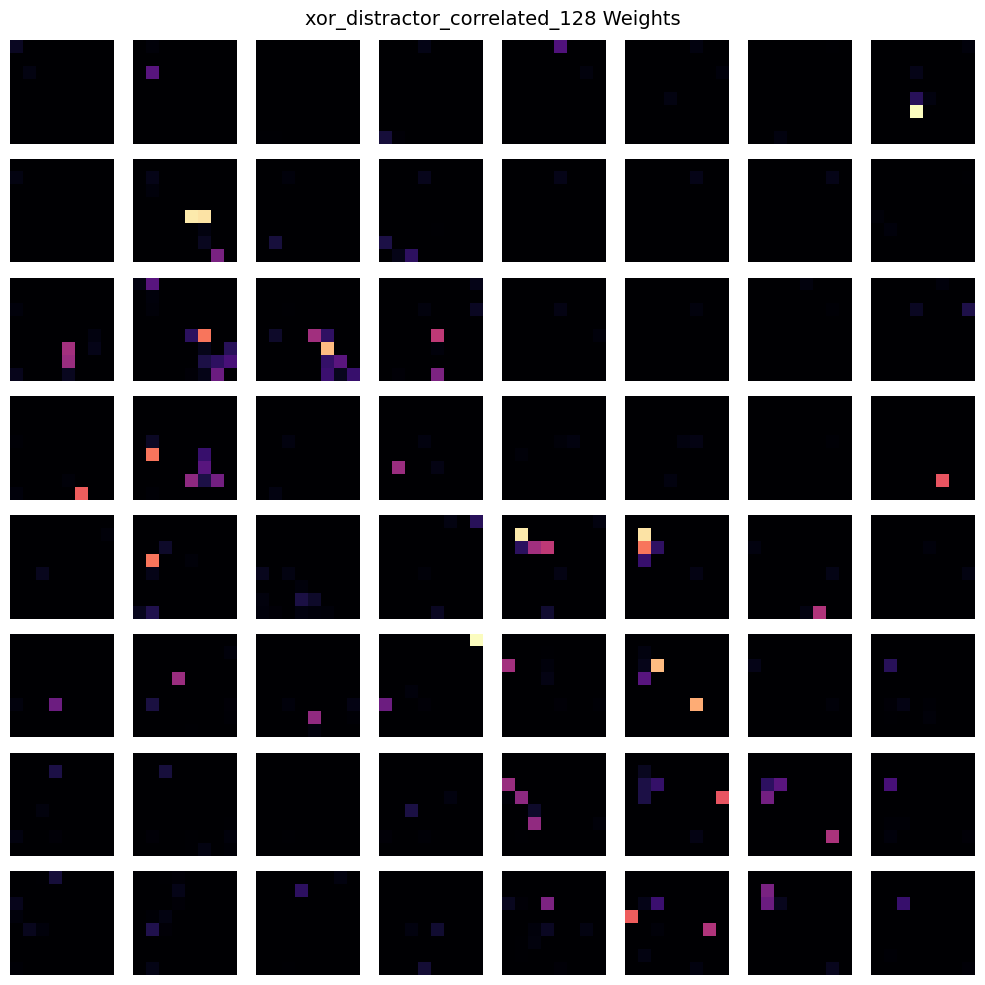

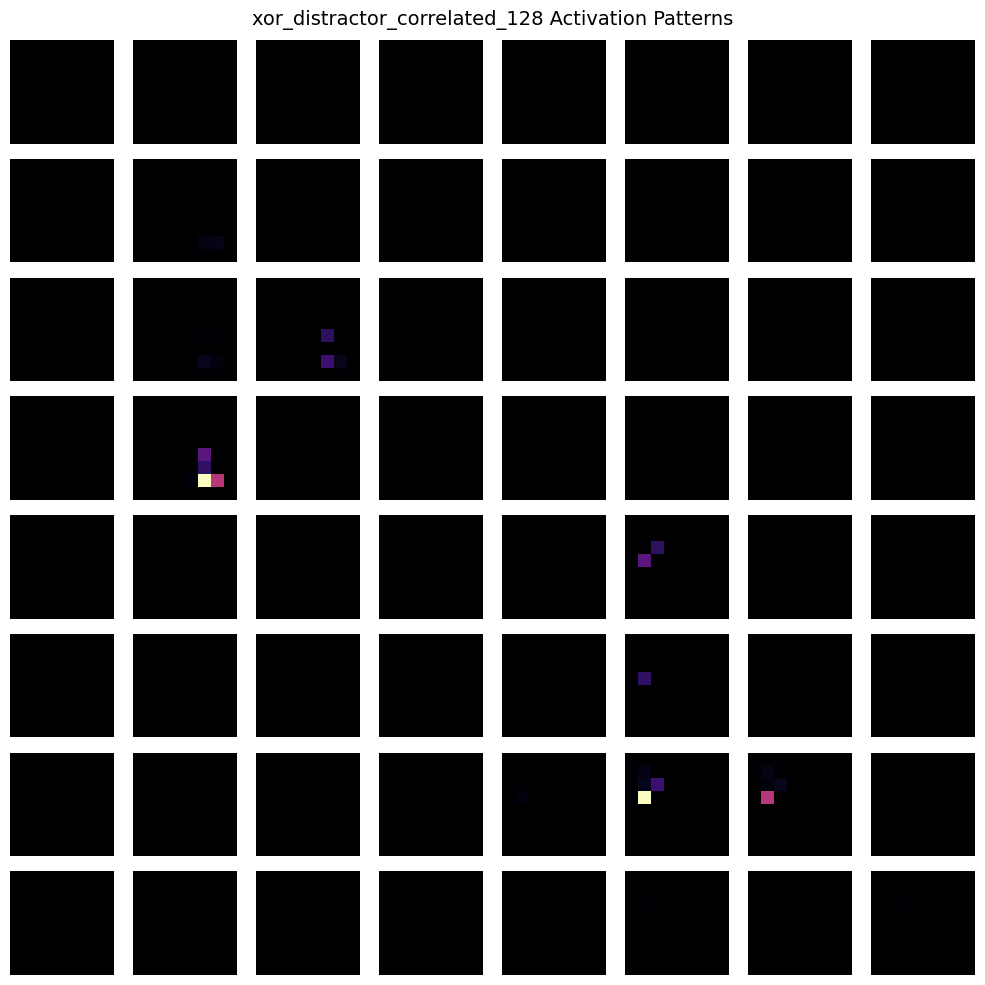

In [11]:
plot_weight_and_signal_grids(
    Z_train=Z_train,
    w=w,
    interaction_pairs=interaction_pairs,
    D=64,
    title_prefix=scen_title,
    filename_prefix=scen_title,
    show=False
)

In [18]:
# plot_shape_functions(
#     model,
#     X_train,
#     patterns,
#     num_cols=8,
#     group1_indices=gt_inds,
#     group2_indices=distractor_inds,
#     group3_indices=overlap_inds,
#     group1_color=rgba_blue,  # light blue
#     group2_color=rgba_orange,  # light orange
#     group3_color=overlap_colour,
#     group1_label="Signal",
#     group2_label="Distractor",
#     group3_label="Overlap",
#     filename=f'{scen_title}_shape_fns_strongsup',
#     figsize=(10, 10),
#     show=False
# )

In [33]:
# if isinstance(X_train, pd.DataFrame):
#     X_train = X_train.to_numpy()

Z_all = []

patterns = []
for learner in model.models:
    learner.eval()
    learner.to(device)  # Move learner to GPU
    with torch.no_grad():
        X_train_tensor = X_train.to(dtype=torch.float32).to(device)
        _, _, main_effects_out, interaction_effects_out = learner.forward(X_train_tensor)
        if interaction_effects_out.shape[1] > 0:
            Z = torch.cat([main_effects_out, interaction_effects_out], dim=1)  # (n_samples, total_units)
        else:
            Z = main_effects_out  # (n_samples, num_features)
        Z_all.append(Z.cpu().numpy())  # move to cpu to convert to numpy

    cov_Z = np.cov(Z.cpu().numpy().T)  # (total_units, total_units)
    
    linreg = LogisticRegression(penalty=None, fit_intercept=False, max_iter=5000, random_state=random_state)
    linreg.fit(Z.cpu().numpy(), y_train)

    w_Z = linreg.coef_[0]  # (total_units,)

    patterns.append(cov_Z @ w_Z)  # (total_units,)

Z_all = np.stack(Z_all, axis=0)  # (num_learners, n_samples, total_units)
Z_mean = np.mean(Z_all, axis=0)  # (n_samples, total_units)


Z_standardised = np.zeros(Z_mean.shape)
for i in range(Z_mean.shape[1]):
    Z_standardised[:,i] = zscore(Z_mean[:,i], nan_policy='omit')
Z_standardised[np.isnan(Z_standardised)] = 0

cov_Z = np.cov(Z_mean.T)  # (total_units, total_units)
cov_Z_st = np.cov(Z_standardised.T)

linreg = LogisticRegression(penalty=None, fit_intercept=False, max_iter=5000, random_state=random_state)
linreg.fit(Z_mean, y_train)

linreg_st = LogisticRegression(penalty=None, fit_intercept=False, max_iter=5000, random_state=random_state)
linreg_st.fit(Z_standardised, y_train)

w_Z = linreg.coef_[0]  # (total_units,)
avg_pattern = cov_Z @ w_Z  # (total_units,)

w_Z_st = linreg_st.coef_[0]  # (total_units,)
avg_pattern_st = cov_Z_st @ w_Z_st  # (total_units,)

In [15]:
# plot_shape_functions(
#     model,
#     X_train,
#     [avg_pattern_st/np.var(Z_standardised @ w_Z_st)],
#     num_cols=8,
#     group1_indices=gt_inds,
#     group2_indices=distractor_inds,
#     group3_indices=overlap_inds,
#     group1_color=rgba_blue,  # light blue
#     group2_color=rgba_orange,  # light orange
#     group3_color=overlap_colour,
#     group1_label="Signal",
#     group2_label="Distractor",
#     group3_label="Overlap",
#     filename=f'{scen_title}_shape_fns_strongsup_st',
#     figsize=(10, 10),
#     show=False
# )

In [21]:
w_Z.shape

(192,)

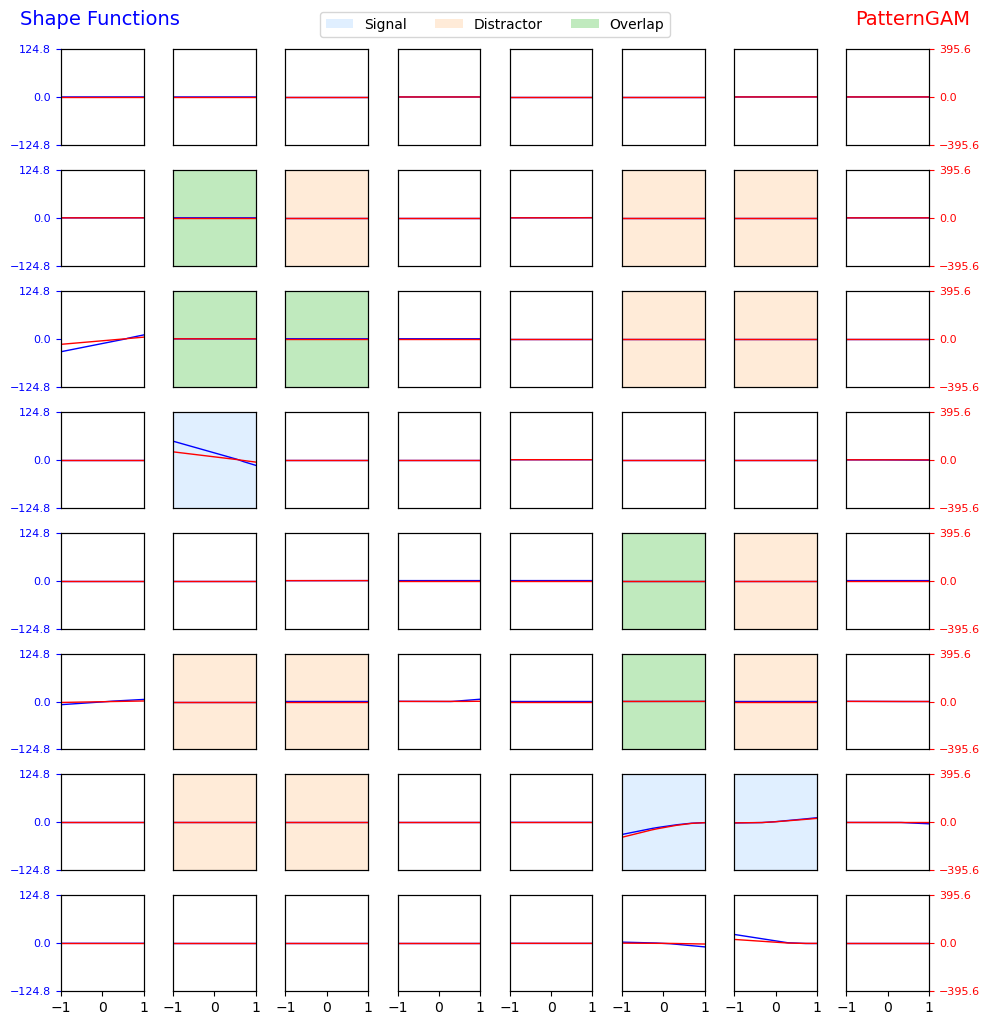

In [24]:
# plot_shape_functions(
#     model,
#     X_train,
#     [avg_pattern_st],
#     num_cols=8,
#     group1_indices=gt_inds,
#     group2_indices=distractor_inds,
#     group3_indices=overlap_inds,
#     group1_color=rgba_blue,  # light blue
#     group2_color=rgba_orange,  # light orange
#     group3_color=overlap_colour,
#     group1_label="Signal",
#     group2_label="Distractor",
#     group3_label="Overlap",
#     filename=f'{scen_title}_shape_fns_strongsup_st',
#     figsize=(10, 10),
#     show=False
# )

In [ ]:
# ------------------------- plotting (shared [0,1] scale) -------------------------
vmin, vmax = 0.0, 1.0

fig, axs = plt.subplots(3, 2, figsize=(8, 8), constrained_layout=True)

im00 = axs[0,0].imshow(w_sum_st_n.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0,0].set_title(f'w_Z_st: sum', fontsize=12)

im01 = axs[1,0].imshow(w_max_st_n.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0,1].set_title(f'w_Z_st: max', fontsize=12)

im10 = axs[0,1].imshow(a_sum_st_n.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1,0].set_title(f'a_st: sum', fontsize=12)

im11 = axs[1,1].imshow(a_max_st_n.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1,1].set_title(f'a_st: max', fontsize=12)

im20 = axs[2,0].imshow(discr_sum.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1,0].set_title(f'a_st: sum', fontsize=12)

im21 = axs[2,1].imshow(discr_max.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1,1].set_title(f'a_st: max', fontsize=12)

for ax in axs.ravel():
    ax.set_xticks([]); ax.set_yticks([])

cbar = fig.colorbar(im11, ax=axs.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('normalised importance', fontsize=12)

plt.show()


In [49]:
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as sk_metrics
import torch

# --------------------------------------------
# Build Z per learner, keep ensemble means
# --------------------------------------------
N, d = X_train.shape
L = len(model.models)

Z_all = []   # list of (N, d+m) per learner
patterns = []

for learner in model.models:
    learner.eval()
    learner.to(device)
    with torch.no_grad():
        X_train_tensor = X_train.to(dtype=torch.float32).to(device)
        _, _, main_effects_out, interaction_effects_out = learner.forward(X_train_tensor)
        if interaction_effects_out.shape[1] > 0:
            Z = torch.cat([main_effects_out, interaction_effects_out], dim=1)  # (N, d+m)
        else:
            Z = main_effects_out  # (N, d)
        Z_np = Z.detach().cpu().numpy()
        Z_all.append(Z_np)

    cov_Z_l = np.cov(Z_np.T)  # (d+m, d+m)
    linreg_l = LogisticRegression(penalty=None, fit_intercept=False, max_iter=5000, random_state=random_state)
    linreg_l.fit(Z_np, y_train)
    w_Z_l = linreg_l.coef_[0]                # (d+m,)
    patterns.append(cov_Z_l @ w_Z_l)         # (d+m,)

Z_all = np.stack(Z_all, axis=0)  # (L, N, d+m)
Z_mean = np.mean(Z_all, axis=0)  # (N, d+m)
total_units = Z_mean.shape[1]
m = total_units - d

# --------------------------------------------
# Standardize Z_mean columnwise (for *_st)
# --------------------------------------------
Z_standardised = np.zeros_like(Z_mean, dtype=np.float64)
for j in range(total_units):
    Z_standardised[:, j] = zscore(Z_mean[:, j], nan_policy='omit')
Z_standardised[np.isnan(Z_standardised)] = 0.0

# --------------------------------------------
# Patterns/weights on raw Z_mean and standardized Z
# --------------------------------------------
cov_Z    = np.cov(Z_mean.T)          # (d+m, d+m)
cov_Z_st = np.cov(Z_standardised.T)  # (d+m, d+m)

linreg      = LogisticRegression(penalty=None, fit_intercept=False, max_iter=5000, random_state=random_state)
linreg.fit(Z_mean, y_train)
w_Z = linreg.coef_[0]                # (d+m,)
avg_pattern = cov_Z @ w_Z            # (d+m,)

linreg_st   = LogisticRegression(penalty=None, fit_intercept=False, max_iter=5000, random_state=random_state)
linreg_st.fit(Z_standardised, y_train)
w_Z_st = linreg_st.coef_[0]          # (d+m,)
avg_pattern_st = cov_Z_st @ w_Z_st   # (d+m,)

# --------------------------------------------
# DISCR for ALL units (mains + interactions)
#   discr_full[j] = max(0, 2*(AUROC(Z_mean[:, j], y) - 0.5))
# --------------------------------------------
y_np = y_train.detach().cpu().numpy().ravel()
discr_full = np.zeros(total_units, dtype=np.float64)

for j in range(total_units):
    s = Z_mean[:, j]  # ensemble-mean activation of unit j (main or interaction)
    try:
        auc = sk_metrics.roc_auc_score(y_np, s)
    except Exception:
        # handle degenerate cases (e.g., single class in y or constant s)
        auc = 0.5
    discr_full[j] = max(0.0, 2.0 * (auc - 0.5))

# Convenience views if you need them separately:
discr_mains = discr_full[:d]         # length d
discr_inters = discr_full[d:]        # length m

# Now available:
#  - w_Z, avg_pattern                (length d+m)
#  - w_Z_st, avg_pattern_st          (length d+m)
#  - discr_full (mains+interactions) (length d+m), plus discr_mains/discr_inters


In [51]:
import numpy as np
import matplotlib.pyplot as plt

# --- transforms (unchanged) ---
def transform_interaction_based(pattern, interaction_pairs=(), d=64):
    pattern = np.asarray(pattern)
    feat_imp = np.zeros(d, dtype=float)
    feat_imp += np.abs(pattern[:d])
    inter_vals = np.abs(pattern[d:])
    for k, (i, j) in enumerate(interaction_pairs):
        v = inter_vals[k]
        feat_imp[i] += v * 0.5
        feat_imp[j] += v * 0.5
    return feat_imp

def transform_interaction_max_signed(pattern, interaction_pairs=(), d=None):
    pattern = np.asarray(pattern)
    m = len(interaction_pairs)
    if d is None:
        d = pattern.size - m
    if d + m != pattern.size or d <= 0:
        raise ValueError("Length mismatch: expected len(pattern) == d + len(interaction_pairs).")
    main = pattern[:d]
    inter = pattern[d:] if m > 0 else np.empty(0, dtype=pattern.dtype)
    adj = [[] for _ in range(d)]
    for k, (i, j) in enumerate(interaction_pairs):
        if not (0 <= i < d and 0 <= j < d):
            raise ValueError(f"interaction_pairs[{k}] = ({i},{j}) out of range [0,{d-1}]")
        adj[i].append(k); adj[j].append(k)
    out = np.empty(d, dtype=float)
    for i in range(d):
        best_val = float(main[i]); best_abs = abs(best_val)
        for k in adj[i]:
            v = float(inter[k]); av = abs(v)
            if av > best_abs:
                best_val = v; best_abs = av
        out[i] = best_val
    return out

# --- normalization helper ---
def normalize_vector(v, mode="max", eps=1e-12):
    v = np.asarray(v, dtype=float)
    if mode == "max":
        denom = np.max(v) if np.max(v) > eps else 1.0
    elif mode == "l1":
        denom = np.sum(v) if np.sum(v) > eps else 1.0
    elif mode == "l2":
        denom = np.sqrt(np.sum(v**2)) if np.sum(v**2) > eps else 1.0
    else:
        raise ValueError("mode must be 'max', 'l1', or 'l2'")
    return v / denom

# ------------------------- apply to *_st only -------------------------
# Assumptions:
# - w_Z_st and avg_pattern_st are np.ndarray of shape (192,)
# - first d=64 entries are mains; remaining are interactions
# - interaction_pairs has length 128 (0-based indices)
d = 64
m = 192 - d
assert len(interaction_pairs) == m, "interaction_pairs must be length 128"
assert w_Z_st.shape == (192,)
assert avg_pattern_st.shape == (192,)

# Build absolute, nonnegative 64-d vectors for each method
w_sum_st  = transform_interaction_based(w_Z_st,         interaction_pairs, d=d)                 # >=0
w_max_st  = np.abs(transform_interaction_max_signed(w_Z_st, interaction_pairs, d=d))           # abs(signed)
a_sum_st  = transform_interaction_based(avg_pattern_st,  interaction_pairs, d=d)                # >=0
a_max_st  = np.abs(transform_interaction_max_signed(avg_pattern_st, interaction_pairs, d=d))   # abs(signed)

discr_sum  = transform_interaction_based(discr_full,  interaction_pairs, d=d)                # >=0
discr_max  = np.abs(transform_interaction_max_signed(discr_full, interaction_pairs, d=d))   # abs(signed)

# Normalize each to the same scale (choose mode: 'max' -> [0,1], or 'l1', 'l2')
norm_mode = "max"  # <- change to 'l1' or 'l2' if preferred
w_sum_st_n = normalize_vector(w_sum_st, mode=norm_mode)
w_max_st_n = normalize_vector(w_max_st, mode=norm_mode)
a_sum_st_n = normalize_vector(a_sum_st, mode=norm_mode)
a_max_st_n = normalize_vector(a_max_st, mode=norm_mode)

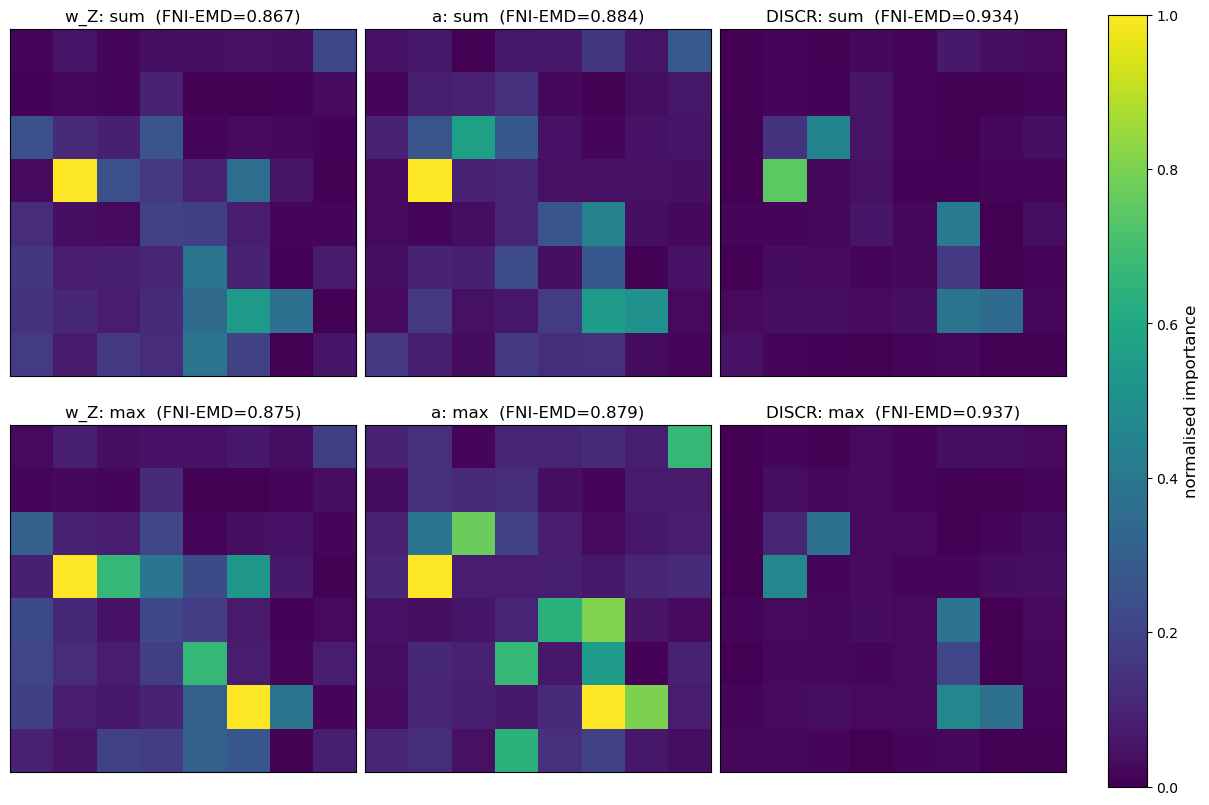

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from ot.lp import emd # Needs POT (Python Optimal Transport) library
from scipy.spatial.distance import cdist


D_2D_EDGE = 8 
D_FLAT = D_2D_EDGE * D_2D_EDGE 

normal_t = np.array([[1,0],[1,1],[1,0]])
normal_l = np.array([[1,0],[1,0],[1,1]])
GT_MASK_2D = np.zeros((D_2D_EDGE, D_2D_EDGE), dtype=int)

# Ensure indices are within bounds for D_2D_EDGE
if D_2D_EDGE >= 7: 
    GT_MASK_2D[1:4, 1:3] = normal_t
    GT_MASK_2D[4:7, 5:7] = normal_l
else:
    print(f"Warning: D_2D_EDGE ({D_2D_EDGE}) is too small for the example GT_MASK_2D pattern. GT Mask will be mostly zeros.")

GT_MASK_2D_FLAT = GT_MASK_2D.flatten()

def create_cost_matrix(grid_edge_length):
    # Creates a cost matrix for a grid of grid_edge_length * grid_edge_length features
    if grid_edge_length == 0:
        return np.array([]).reshape(0,0)
    
    total_features = grid_edge_length * grid_edge_length
    if total_features == 1:
        return np.array([[0.0]])
        
    indices_matrix = np.indices((grid_edge_length, grid_edge_length))
    coordinates = []
    for r in range(grid_edge_length):
        for c in range(grid_edge_length):
            coordinates.append((indices_matrix[0][r, c], indices_matrix[1][r, c]))
    coordinates = np.array(coordinates)
    return cdist(coordinates, coordinates)

# Cost matrix for main effects (e.g., 8x8 grid -> 64 features)
COST_MATRIX_MAIN_EFFECTS = create_cost_matrix(D_2D_EDGE)


def calculate_emd_score_metric(gt_mask_flat, attribution_flat, grid_edge_length, base_cost_matrix, is_fpi=False):
    # Input checks
    if not (isinstance(gt_mask_flat, np.ndarray) and gt_mask_flat.ndim == 1 and
            isinstance(attribution_flat, np.ndarray) and attribution_flat.ndim == 1 and
            len(gt_mask_flat) == len(attribution_flat) and
            len(gt_mask_flat) == grid_edge_length * grid_edge_length):
        return np.nan

    current_cost_matrix = np.copy(base_cost_matrix)
    if is_fpi:
        gt_indices = np.where(gt_mask_flat == 1)[0]
        for r_idx in gt_indices:
            for c_idx in gt_indices:
                if r_idx < current_cost_matrix.shape[0] and c_idx < current_cost_matrix.shape[1]:
                    current_cost_matrix[r_idx, c_idx] = 0.0
    
    sum_gt = np.sum(gt_mask_flat)
    abs_attribution = np.abs(attribution_flat)
    sum_attr = np.sum(abs_attribution)

    if sum_gt < 1e-9 and sum_attr < 1e-9:
        return 1.0
    if sum_gt < 1e-9 or sum_attr < 1e-9:
        return 0.0
        
    dist_gt = gt_mask_flat.astype(np.float64) / sum_gt
    dist_attr = abs_attribution.astype(np.float64) / sum_attr
    
    # Ensure C-contiguous float64
    dist_gt_c = np.ascontiguousarray(dist_gt, dtype=np.float64)
    dist_attr_c = np.ascontiguousarray(dist_attr, dtype=np.float64)
    current_cost_matrix_c = np.ascontiguousarray(current_cost_matrix, dtype=np.float64)

    cost_val = 0.0
    if grid_edge_length * grid_edge_length > 1:
        try:
            _, cost_val = emd(dist_gt_c, dist_attr_c, current_cost_matrix_c, numItermax=200000, log=True)
        except Exception:
            return np.nan
    
    # Max possible Euclidean distance on the grid
    d_max = np.sqrt(2 * (grid_edge_length - 1)**2) if grid_edge_length > 1 else 0.0
    if d_max == 0:
        return 1.0 if np.isclose(cost_val, 0) else 0.0
    
    return 1 - (cost_val['cost'] / d_max)

# =========================
# Build cost & compute EMD
# =========================
D_2D_EDGE = 8
COST_MATRIX_MAIN_EFFECTS = create_cost_matrix(D_2D_EDGE)

# GT mask mains (you already created GT_MASK_2D_FLAT); ensure it's 1D and length 64
gt_flat = GT_MASK_2D_FLAT.astype(int).ravel()
assert gt_flat.size == D_2D_EDGE * D_2D_EDGE, "GT mask must be 8x8 flattened."

# ---- If you need DISCR redistributed maps here (optional) ----
# (Uncomment if not already available in your session)
# discr_sum = normalize_vector(transform_interaction_based(discr_full, interaction_pairs, d=64), mode="max")
# discr_max = normalize_vector(np.abs(transform_interaction_max_signed(discr_full, interaction_pairs, d=64)), mode="max")

# All maps must be 8x8 (length 64). If they are 64-d already normalized to [0,1], great.
maps = {
    "w_Z_st: sum": np.asarray(w_sum_st_n).ravel(),
    "w_Z_st: max": np.asarray(w_max_st_n).ravel(),
    "a_st: sum":   np.asarray(a_sum_st_n).ravel(),
    "a_st: max":   np.asarray(a_max_st_n).ravel(),
    "DISCR: sum":  np.asarray(discr_sum).ravel(),
    "DISCR: max":  np.asarray(discr_max).ravel(),
}

# Compute EMD (is_fpi=True) for each map
scores = {}
for name, vec in maps.items():
    if vec.size != D_2D_EDGE * D_2D_EDGE:
        raise ValueError(f"{name} has length {vec.size}, expected {D_2D_EDGE*D_2D_EDGE}.")
    scores[name] = calculate_emd_score_metric(
        gt_mask_flat=gt_flat,
        attribution_flat=vec,
        grid_edge_length=D_2D_EDGE,
        base_cost_matrix=COST_MATRIX_MAIN_EFFECTS,
        is_fpi=True
    )

# =========================
# Plot with EMD in titles
# =========================
vmin, vmax = 0.0, 1.0
fig, axs = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Row 0
im00 = axs[0,0].imshow(maps["w_Z_st: sum"].reshape(D_2D_EDGE, D_2D_EDGE), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0,0].set_title(f'w_Z: sum  (FNI-EMD={scores["w_Z_st: sum"]:.3f})', fontsize=12)

im10 = axs[0,1].imshow(maps["a_st: sum"].reshape(D_2D_EDGE, D_2D_EDGE), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0,1].set_title(f'a: sum  (FNI-EMD={scores["a_st: sum"]:.3f})', fontsize=12)

im20 = axs[0,2].imshow(maps["DISCR: sum"].reshape(D_2D_EDGE, D_2D_EDGE), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0,2].set_title(f'DISCR: sum  (FNI-EMD={scores["DISCR: sum"]:.3f})', fontsize=12)





# Row 1

im01 = axs[1,0].imshow(maps["w_Z_st: max"].reshape(D_2D_EDGE, D_2D_EDGE), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1,0].set_title(f'w_Z: max  (FNI-EMD={scores["w_Z_st: max"]:.3f})', fontsize=12)

im11 = axs[1,1].imshow(maps["a_st: max"].reshape(D_2D_EDGE, D_2D_EDGE), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1,1].set_title(f'a: max  (FNI-EMD={scores["a_st: max"]:.3f})', fontsize=12)

im21 = axs[1,2].imshow(maps["DISCR: max"].reshape(D_2D_EDGE, D_2D_EDGE), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1,2].set_title(f'DISCR: max  (FNI-EMD={scores["DISCR: max"]:.3f})', fontsize=12)

for ax in axs.ravel():
    ax.set_xticks([]); ax.set_yticks([])

# One shared colorbar
cbar = fig.colorbar(im11, ax=axs.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('normalised importance', fontsize=12)

plt.show()


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics

def plot_weight_and_signal_grids(
    Z_train,                 # shape (N, D+m): per-sample activations for mains + interactions
    w,                       # shape (D+m,)
    interaction_pairs,       # list of (i, j) pairs (0-based) for interactions, length m
    D,                       # number of main features
    y_train,                 # shape (N,) labels (0/1), used for DISCR
    title_prefix="",
    filename_prefix="",
    cmap='magma',
    show=False
):
    """
    Plots three grids per feature (as an 8x8 panel per feature):
      1) Weights (|w| redistributed to a D x D matrix)
      2) Activation Patterns (|Σ_Z w| redistributed)
      3) DISCR (per-unit AUROC mapped to [0,1], redistributed)

    Redistribution: mains go on the diagonal, interactions populate (i,j) and (j,i).
    """

    # ----------------- Step 1: Compute signal = Σ_Z w -----------------
    Sigma_Z  = np.cov(Z_train.T)                  # (D+m, D+m)
    signal_Z = Sigma_Z @ w                        # (D+m,)

    # Take magnitudes for the first two views (matches your original behavior)
    w_abs      = np.abs(w)
    signal_abs = np.abs(signal_Z)

    main_weights = w_abs[:D]
    inter_weights = w_abs[D:]
    main_signal = signal_abs[:D]
    inter_signal = signal_abs[D:]

    # ----------------- Step 2: Compute DISCR for ALL units -----------------
    # For each unit j (main or interaction), AUROC(Z_train[:, j], y), mapped as max(0, 2*(auc-0.5))
    y_np = np.asarray(y_train).ravel()
    total_units = Z_train.shape[1]
    assert total_units == D + len(interaction_pairs), "Mismatch between Z_train width and interaction_pairs+D"

    discr_full = np.zeros(total_units, dtype=float)
    for j in range(total_units):
        s = Z_train[:, j]
        try:
            auc = sk_metrics.roc_auc_score(y_np, s)
        except Exception:
            auc = 0.5
        discr_full[j] = max(0.0, 2.0*(auc - 0.5))   # in [0,1]

    main_discr = discr_full[:D]
    inter_discr = discr_full[D:]

    # ----------------- Step 3: Build redistribution matrices -----------------
    full_weights_matrix = np.zeros((D, D), dtype=float)
    full_signal_matrix  = np.zeros((D, D), dtype=float)
    full_discr_matrix   = np.zeros((D, D), dtype=float)

    # mains -> diagonal
    for i in range(D):
        full_weights_matrix[i, i] = main_weights[i]
        full_signal_matrix[i, i]  = main_signal[i]
        full_discr_matrix[i, i]   = main_discr[i]

    # interactions -> symmetric off-diagonals
    for idx, (i, j) in enumerate(interaction_pairs):
        v_w  = inter_weights[idx]
        v_s  = inter_signal[idx]
        v_d  = inter_discr[idx]
        full_weights_matrix[i, j] += v_w; full_weights_matrix[j, i] += v_w
        full_signal_matrix[i, j]  += v_s; full_signal_matrix[j, i]  += v_s
        full_discr_matrix[i, j]   += v_d; full_discr_matrix[j, i]   += v_d

    # ----------------- Step 4: Plotting helper -----------------
    def plot_feature_grid(matrix, title, filename, show=show):
        fig, axs = plt.subplots(8, 8, figsize=(10, 10))
        vmax = np.max(np.abs(matrix))
        for k in range(D):
            ax = axs[k // 8, k % 8]
            image = matrix[k].reshape(8, 8)
            im = ax.imshow(image, cmap=cmap, vmin=0, vmax=vmax)
            ax.axis('off')
        fig.suptitle(title, fontsize=14, y=0.98)
        plt.tight_layout()
        plt.savefig(f'./figures/{filename}.png', bbox_inches='tight')
        plt.savefig(f'./figures/{filename}_hires.png', bbox_inches='tight', dpi=300)
        if show:
            plt.show()
        plt.close(fig)

    # ----------------- Step 5: Plot all three -----------------
    plot_feature_grid(full_weights_matrix, f"{title_prefix} Weights",               f"{filename_prefix}_weights")
    plot_feature_grid(full_signal_matrix,  f"{title_prefix} Activation Patterns",  f"{filename_prefix}_patterns")
    plot_feature_grid(full_discr_matrix,   f"{title_prefix} DISCR (AUROC-mapped)", f"{filename_prefix}_discr")


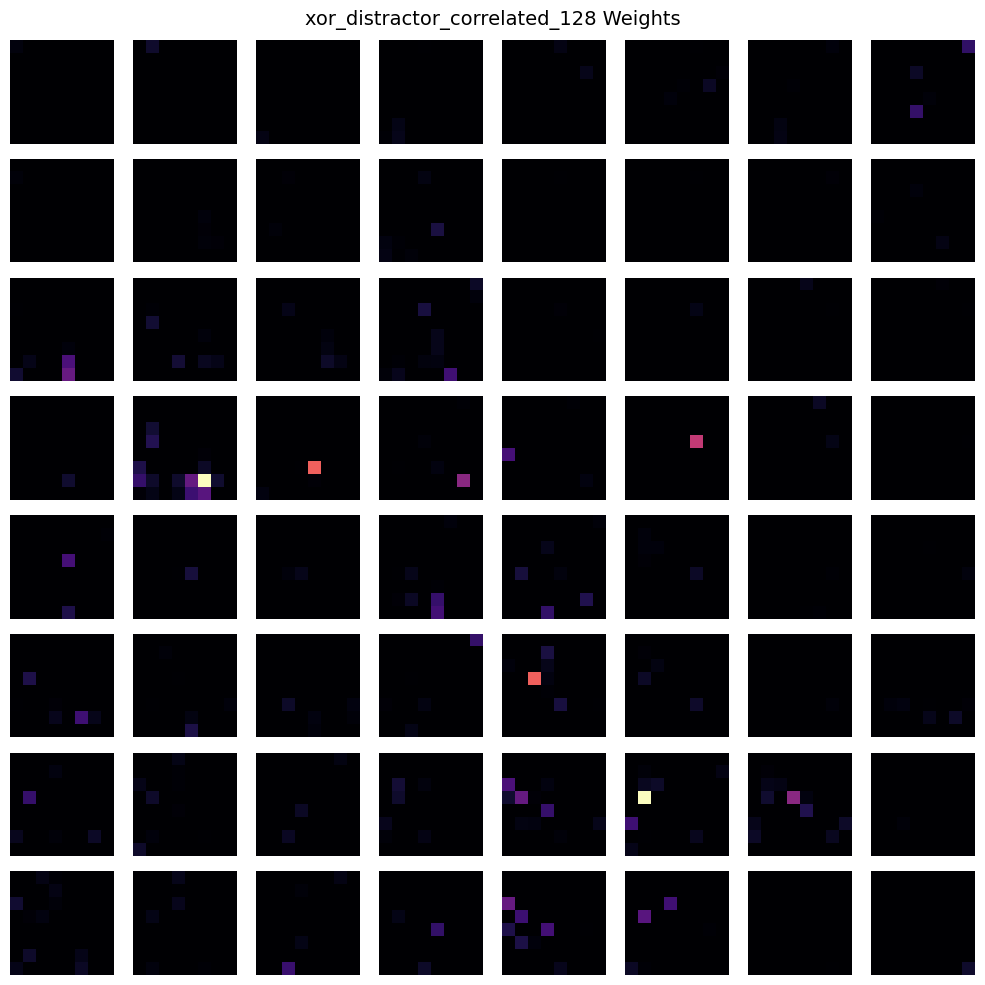

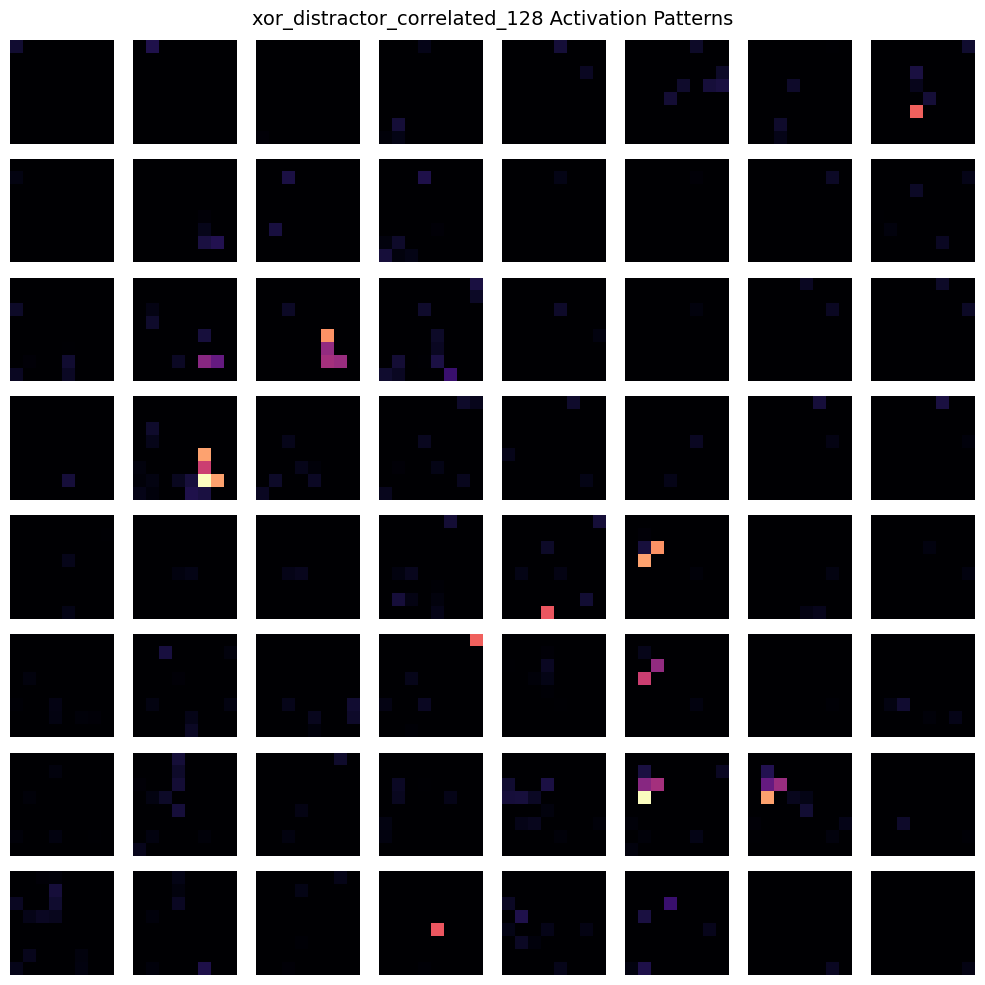

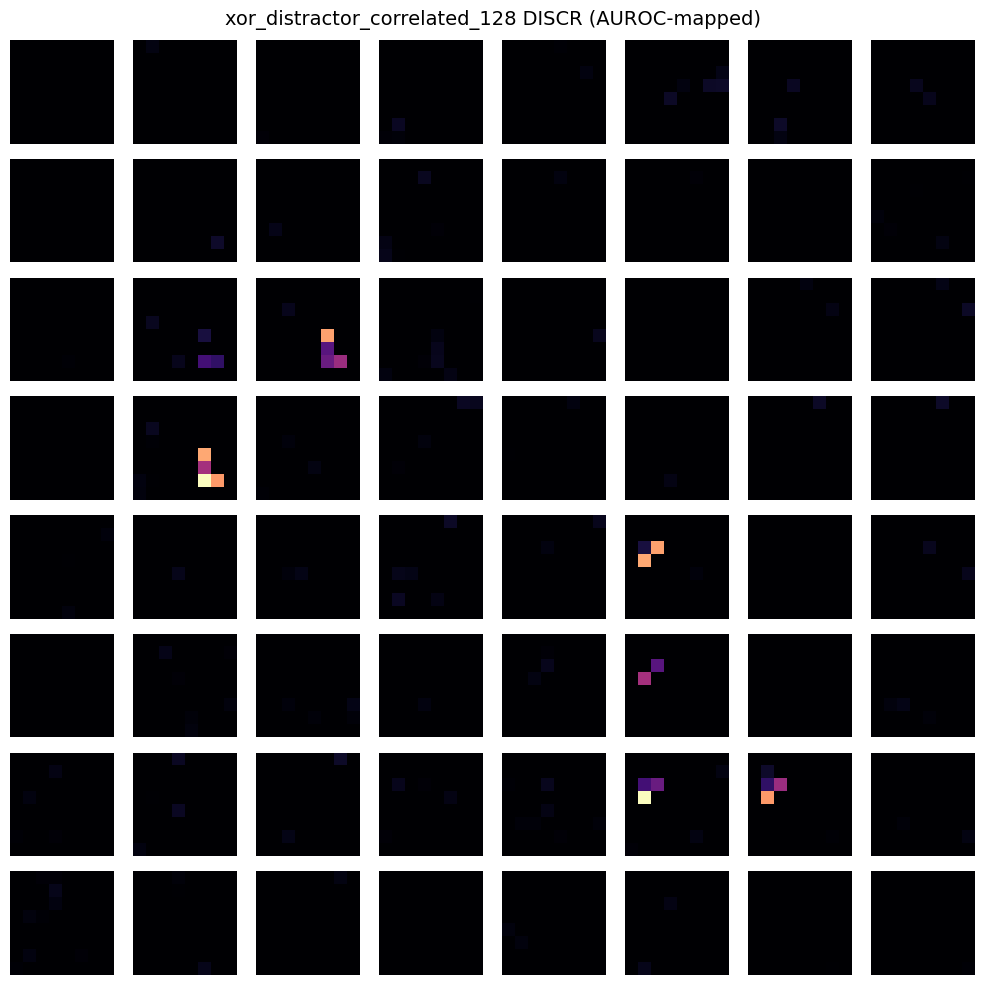

In [72]:
plot_weight_and_signal_grids(
    Z_train=Z_standardised,
    w=w_Z_st,
    interaction_pairs=interaction_pairs,
    D=64,
    y_train=y_train,
    title_prefix=scen_title,
    filename_prefix=scen_title,
    show=True
)

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics

def plot_weight_signal_discr_side_by_side(
    Z_train,                 # (N, D+m): per-sample activations (mains + interactions)
    w,                       # (D+m,)
    interaction_pairs,       # list[(i,j)] of length m
    D,                       # number of main features (assumes 8x8 -> D=64)
    y_train,                 # (N,) labels (0/1) for DISCR
    *,
    title_prefix="",
    cmap='magma',
    share_scale=True,        # use one vmax for all three panels
    show=True,
    save_path=None           # e.g., "./figures/triptych.png"
):
    """
    Builds three D×D matrices (weights, patterns, DISCR), converts each to a single
    64×64 montage (8×8 tiles of 8×8 patches), and displays them side-by-side.

    Redistribution: mains -> diagonal; interactions -> symmetric (i,j) and (j,i).
    Weights & patterns are shown as absolute magnitudes; DISCR in [0,1].
    """

    assert int(np.sqrt(D))**2 == D, "D must be a perfect square (expected 8x8 -> 64)."
    EDGE = int(np.sqrt(D))
    total_units = Z_train.shape[1]
    m = total_units - D
    assert m == len(interaction_pairs), "Z_train width must match D + len(interaction_pairs)."

    # ----- 1) Patterns (signal) = Σ_Z w -----
    Sigma_Z  = np.cov(Z_train.T)      # (D+m, D+m)
    signal_Z = Sigma_Z @ w            # (D+m,)

    # Magnitudes for the first two views
    w_abs      = np.abs(w)
    signal_abs = np.abs(signal_Z)

    main_w  = w_abs[:D];     inter_w  = w_abs[D:]
    main_s  = signal_abs[:D];inter_s  = signal_abs[D:]

    # ----- 2) DISCR for ALL units (mains + interactions) -----
    y_np = np.asarray(y_train).ravel()
    discr_full = np.zeros(total_units, dtype=float)
    for j in range(total_units):
        s = Z_train[:, j]
        try:
            auc = sk_metrics.roc_auc_score(y_np, s)
        except Exception:
            auc = 0.5
        discr_full[j] = max(0.0, 2.0*(auc - 0.5))  # in [0,1]
    main_d = discr_full[:D]; inter_d = discr_full[D:]

    # ----- 3) Build D×D redistribution matrices -----
    Wmat = np.zeros((D, D), dtype=float)
    Smat = np.zeros((D, D), dtype=float)
    Dmat = np.zeros((D, D), dtype=float)

    # mains on diagonal
    for i in range(D):
        Wmat[i, i] = main_w[i]
        Smat[i, i] = main_s[i]
        Dmat[i, i] = main_d[i]

    # interactions to symmetric off-diagonals
    for k, (i, j) in enumerate(interaction_pairs):
        Wmat[i, j] += inter_w[k]; Wmat[j, i] += inter_w[k]
        Smat[i, j] += inter_s[k]; Smat[j, i] += inter_s[k]
        Dmat[i, j] += inter_d[k]; Dmat[j, i] += inter_d[k]

    # ----- 4) Convert each D×D matrix into a single 64×64 montage -----
    def matrix_to_montage(M, edge=EDGE):
        """
        Treat row k of M as a flattened 8×8 patch; tile patches into an edge×edge grid.
        Returns (edge*8, edge*8) image.
        """
        montage = np.zeros((edge*8, edge*8), dtype=float)
        for k in range(D):
            r = k // edge
            c = k % edge
            patch = M[k].reshape(8, 8)
            montage[r*8:(r+1)*8, c*8:(c+1)*8] = patch
        return montage

    Wimg = matrix_to_montage(Wmat, EDGE)
    Simg = matrix_to_montage(Smat, EDGE)
    Dimg = matrix_to_montage(Dmat, EDGE)

    # ----- 5) Plot side-by-side -----
    if share_scale:
        vmax = max(Wimg.max(), Simg.max(), Dimg.max())
        vmins = [0.0, 0.0, 0.0]; vmaxs = [vmax, vmax, vmax]
    else:
        vmins = [0.0, 0.0, 0.0]
        vmaxs = [Wimg.max(), Simg.max(), Dimg.max()]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    titles = [f"{title_prefix} Weights |w|",
              f"{title_prefix} Activation Patterns |Σw|",
              f"{title_prefix} DISCR (AUROC→[0,1])"]

    imgs = []
    for ax, img, vmin, vmax, ttl in zip(axes, [Wimg, Simg, Dimg], vmins, vmaxs, titles):
        im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(ttl, fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
        imgs.append(im)

    # single shared colorbar (uses last im's norm, which matches if share_scale=True)
    cbar = fig.colorbar(imgs[-1], ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    cbar.set_label("magnitude", fontsize=11)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    if show:
        plt.show()
    else:
        plt.close(fig)


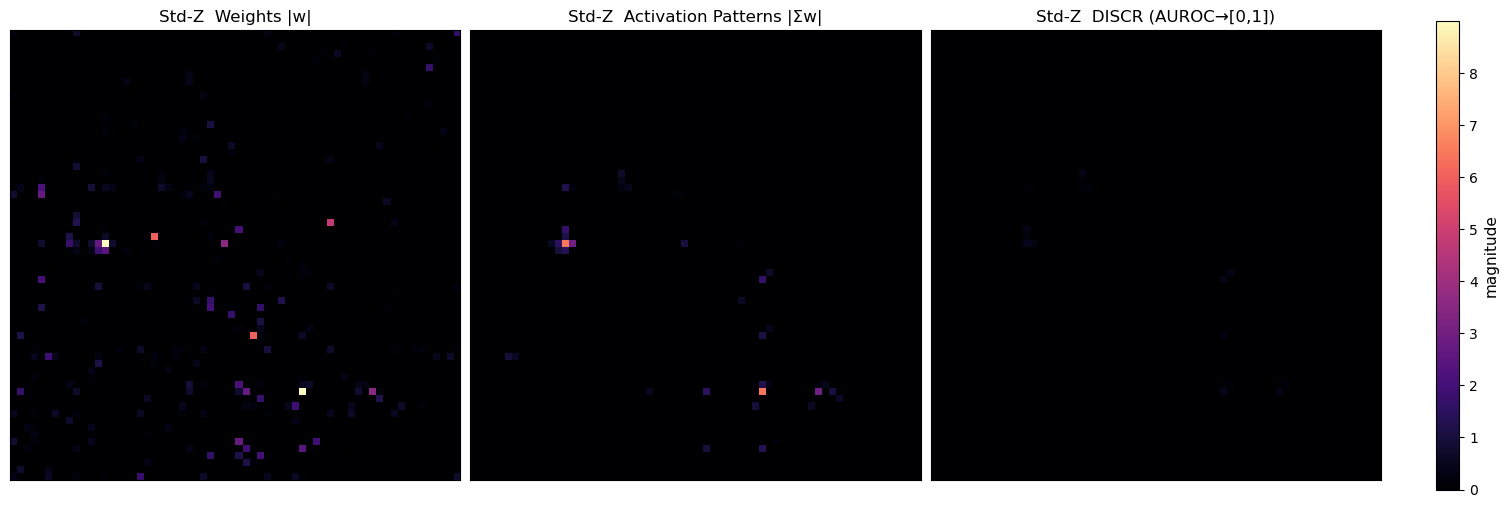

In [74]:
plot_weight_signal_discr_side_by_side(
    Z_train=Z_mean,                 # or your per-sample Z you want to analyze
    w=w_Z_st,                       # or w_Z, depending on which you’re inspecting
    interaction_pairs=interaction_pairs,
    D=64,
    y_train=y_train.cpu().numpy(),  # or y_train if already np
    title_prefix="Std-Z ",
    cmap='magma',
    share_scale=True,               # same color scale across all three
    show=True,
    save_path=None
)
